##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install numpy
# %pip install missingno
# %pip install scikit-learn
# %pip install mlxtend
# %pip install xgboost

### Loading Data

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer

ImportError: cannot import name 'artist' from 'matplotlib' (C:\Users\fengq\miniconda3\lib\site-packages\matplotlib\__init__.py)

In [4]:
filepath = "./data/catB_train.parquet"

data = pd.read_parquet(filepath)
data["f_purchase_lh"] = data["f_purchase_lh"].fillna(0.0, inplace=False)
data = data.fillna(value=np.nan)

print(len(data))
display(data.head())

# for col in data.columns:
#     print(col)

17992


clntnum race_desc ctrycode_desc clttype stat_flag min_occ_date  \
19550  91b546e924   Chinese     Singapore       P    ACTIVE   2017-10-31   
4600   896bae548c   Chinese     Singapore       P    ACTIVE   2007-05-23   
13337  f364439ae6    Others     Singapore       P    ACTIVE   2019-08-31   
15074  70f319cfe1   Chinese     Singapore       P    ACTIVE   2021-10-18   
19724  2647a81328   Chinese     Singapore       P    ACTIVE   2018-07-20   

       cltdob_fix cltsex_fix  flg_substandard  flg_is_borderline_standard  \
19550  1974-05-09     Female              0.0                         0.0   
4600   1979-11-11       Male              0.0                         0.0   
13337  1976-01-28       Male              0.0                         0.0   
15074  1976-03-19     Female              0.0                         0.0   
19724  1995-07-31     Female              0.0                         0.0   

       ...  recency_giclaim  giclaim_cnt_success  recency_giclaim_success  \
19550  ...              NaN                  NaN                      NaN   
4600   ...              NaN                  NaN                      NaN   
13337  ...              NaN                  NaN                      NaN   
15074  ...              NaN                  NaN                      NaN   
19724  ...              NaN                  NaN                      NaN   

       giclaim_cnt_unsuccess  recency_giclaim_unsuccess  \
19550                    NaN                        NaN   
4600                     NaN                        NaN   
13337                    NaN                        NaN   
15074                    NaN                        NaN   
19724                    NaN                        NaN   

       flg_gi_claim_29d435_ever  flg_gi_claim_058815_ever  \
19550                       NaN                       NaN   
4600                        NaN                       NaN   
13337                       NaN                       NaN   
15074                       NaN                       NaN   
19724                       NaN                       NaN   

       flg_gi_claim_42e115_ever  flg_gi_claim_856320_ever  f_purchase_lh  
19550                       NaN                       NaN            0.0  
4600                        NaN                       NaN            0.0  
13337                       NaN                       NaN            0.0  
15074                       NaN                       NaN            0.0  
19724                       NaN                       NaN            0.0  

[5 rows x 304 columns]

### Utils

In [5]:
def missing_values_table(df):
    # credit: https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


def to_cat_dtype(columns, df):
    for col in columns:
        df[col] = df[col].fillna(0.0).astype(np.int8)

    return df

### Null Value Analysis

##### Bar chart representing the count of non-null values for each column

<Axes: >

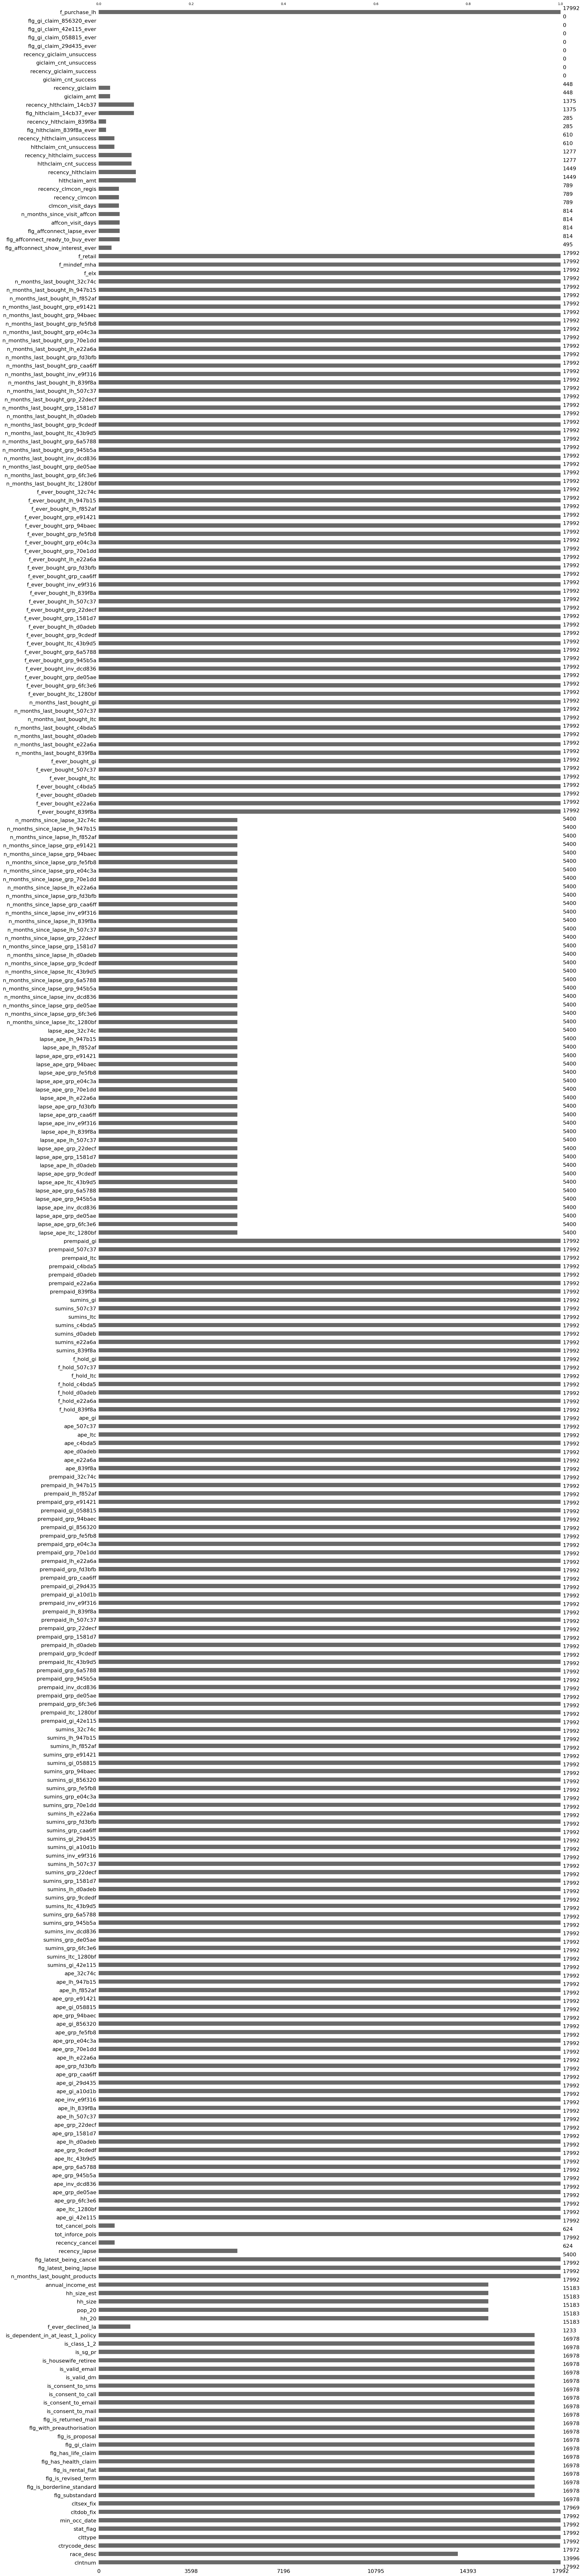

In [6]:
msno.bar(data)

We can see that many columns contains null values, some are completely filled with null values.

##### We can access the distribution and information of the null values by creating the following dataframe

In [7]:
nan_df = missing_values_table(data)
nan_df

Your selected dataframe has 304 columns.
There are 110 columns that have missing values.


Missing Values  % of Total Values
flg_gi_claim_856320_ever                    17992              100.0
flg_gi_claim_42e115_ever                    17992              100.0
flg_gi_claim_058815_ever                    17992              100.0
flg_gi_claim_29d435_ever                    17992              100.0
recency_giclaim_unsuccess                   17992              100.0
...                                           ...                ...
is_sg_pr                                     1014                5.6
is_class_1_2                                 1014                5.6
is_dependent_in_at_least_1_policy            1014                5.6
cltsex_fix                                     23                0.1
ctrycode_desc                                  20                0.1

[110 rows x 2 columns]

Two interesting observations are columns that contains the word "lapse" and columns with `"% of Total Values" == 5.6` have the same amount of null values, thus missing values in this case might contain useful informations.

##### Visualizing the Locations of the missing data

<Axes: >

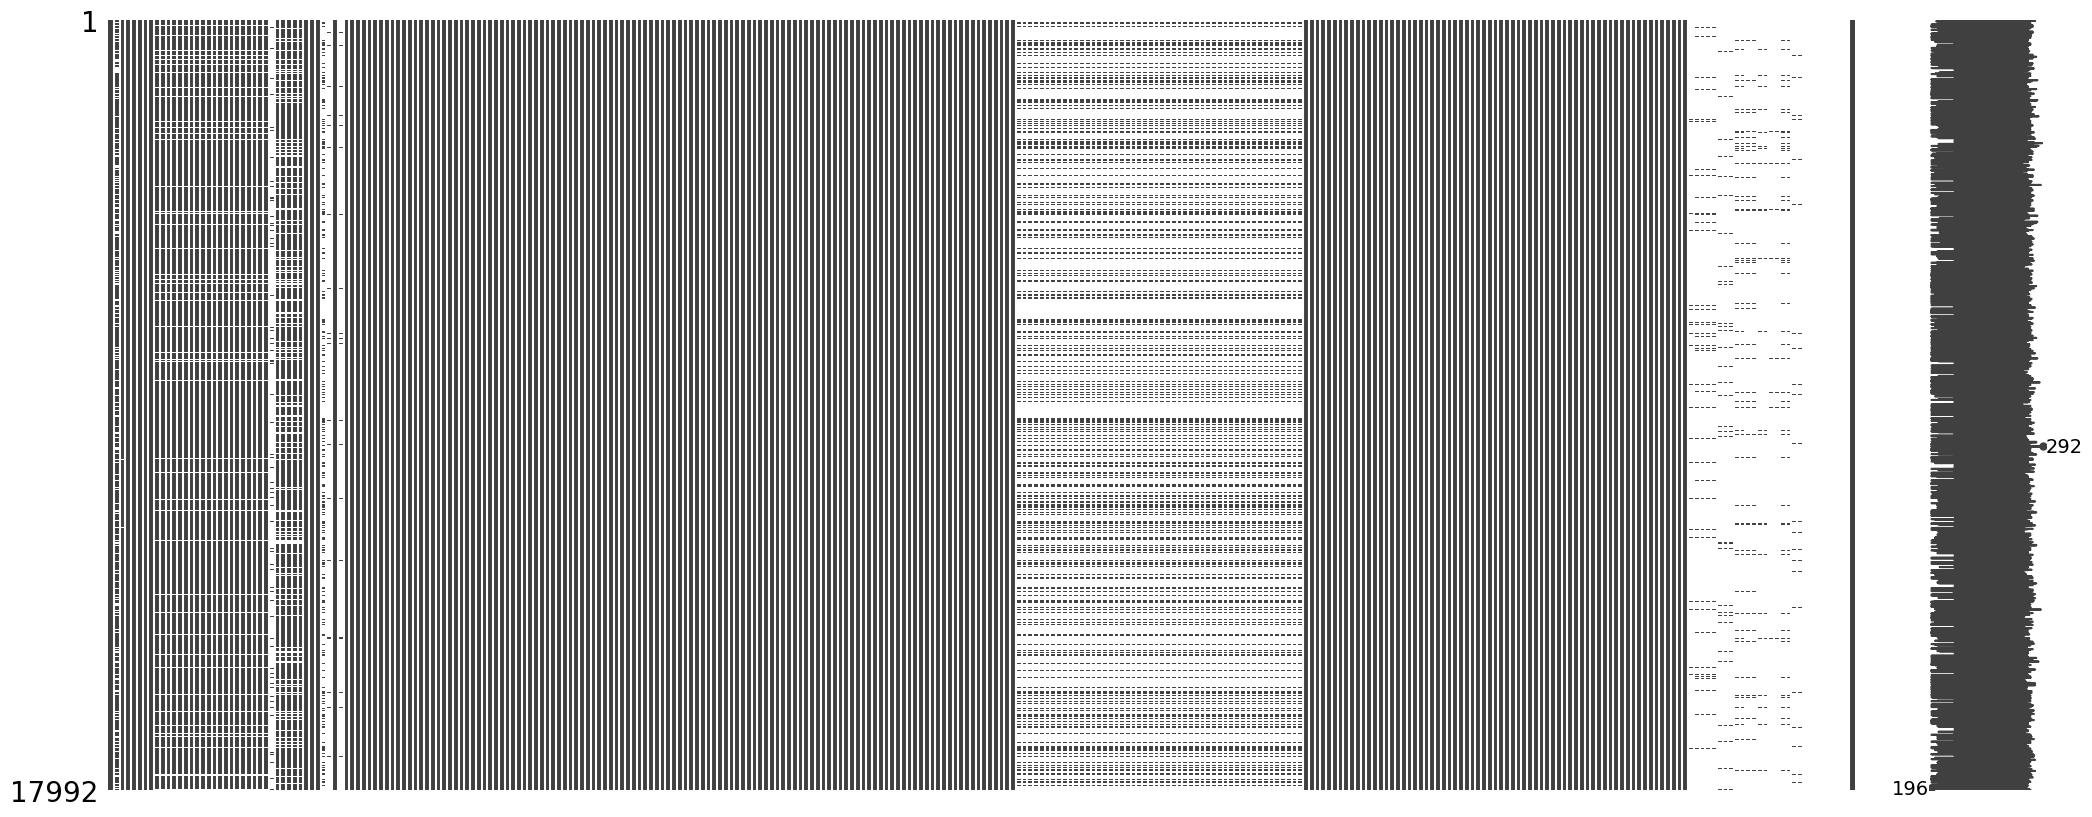

In [8]:
msno.matrix(data)

We can see that some columns have missing data at the same locations

##### Deleting Columns with 100% null values

In [9]:
columns_to_drop = nan_df[nan_df["% of Total Values"] == 100].index.values
print(columns_to_drop)

['flg_gi_claim_856320_ever' 'flg_gi_claim_42e115_ever'
 'flg_gi_claim_058815_ever' 'flg_gi_claim_29d435_ever'
 'recency_giclaim_unsuccess' 'giclaim_cnt_unsuccess'
 'recency_giclaim_success' 'giclaim_cnt_success']


In [10]:
data_cleaned_v1 = data.drop(columns=columns_to_drop)

nan_df_v1 = missing_values_table(data_cleaned_v1)

nan_df_v1

Your selected dataframe has 296 columns.
There are 102 columns that have missing values.


Missing Values  % of Total Values
recency_hlthclaim_839f8a                    17707               98.4
flg_hlthclaim_839f8a_ever                   17707               98.4
recency_giclaim                             17544               97.5
giclaim_amt                                 17544               97.5
flg_affconnect_show_interest_ever           17497               97.2
...                                           ...                ...
is_sg_pr                                     1014                5.6
is_class_1_2                                 1014                5.6
is_consent_to_email                          1014                5.6
cltsex_fix                                     23                0.1
ctrycode_desc                                  20                0.1

[102 rows x 2 columns]

##### Investigating Columns with 90% and above null values

In [11]:
columns_90 = nan_df_v1[nan_df_v1["% of Total Values"] >= 90].index.values
print(columns_90)

['recency_hlthclaim_839f8a' 'flg_hlthclaim_839f8a_ever' 'recency_giclaim'
 'giclaim_amt' 'flg_affconnect_show_interest_ever'
 'recency_hlthclaim_unsuccess' 'hlthclaim_cnt_unsuccess' 'tot_cancel_pols'
 'recency_cancel' 'clmcon_visit_days' 'recency_clmcon_regis'
 'recency_clmcon' 'flg_affconnect_ready_to_buy_ever' 'affcon_visit_days'
 'n_months_since_visit_affcon' 'flg_affconnect_lapse_ever'
 'f_ever_declined_la' 'hlthclaim_cnt_success' 'recency_hlthclaim_success'
 'recency_hlthclaim_14cb37' 'flg_hlthclaim_14cb37_ever' 'hlthclaim_amt'
 'recency_hlthclaim']


In [12]:
data_cleaned_v1[columns_90].describe()

recency_hlthclaim_839f8a  flg_hlthclaim_839f8a_ever  recency_giclaim  \
count                285.000000                      285.0       448.000000   
mean                  46.077193                        1.0        39.997768   
std                   34.288046                        0.0        30.329252   
min                    0.000000                        1.0         0.000000   
25%                   18.000000                        1.0        12.000000   
50%                   42.000000                        1.0        40.000000   
75%                   72.000000                        1.0        58.000000   
max                  124.000000                        1.0       144.000000   

       flg_affconnect_show_interest_ever  recency_hlthclaim_unsuccess  \
count                              495.0                   610.000000   
mean                                 1.0                    49.409836   
std                                  0.0                    34.932248   
min                                  1.0                     0.000000   
25%                                  1.0                    18.000000   
50%                                  1.0                    45.000000   
75%                                  1.0                    78.000000   
max                                  1.0                   126.000000   

       hlthclaim_cnt_unsuccess  tot_cancel_pols  recency_cancel  \
count               610.000000       624.000000      624.000000   
mean                  2.455738         1.217949       47.964744   
std                   3.694247         0.592027       31.410277   
min                   1.000000         1.000000        1.000000   
25%                   1.000000         1.000000       16.000000   
50%                   2.000000         1.000000       47.000000   
75%                   3.000000         1.000000       73.000000   
max                  68.000000         6.000000      147.000000   

       clmcon_visit_days  recency_clmcon_regis  ...  \
count         789.000000            789.000000  ...   
mean            5.088720             29.019011  ...   
std             6.034775             24.640633  ...   
min             1.000000              0.000000  ...   
25%             1.000000              8.000000  ...   
50%             3.000000             21.000000  ...   
75%             6.000000             47.000000  ...   
max            56.000000             92.000000  ...   

       flg_affconnect_ready_to_buy_ever  affcon_visit_days  \
count                             814.0         814.000000   
mean                                1.0           2.710074   
std                                 0.0           3.462606   
min                                 1.0           1.000000   
25%                                 1.0           1.000000   
50%                                 1.0           2.000000   
75%                                 1.0           3.000000   
max                                 1.0          50.000000   

       n_months_since_visit_affcon  flg_affconnect_lapse_ever  \
count                   814.000000                 814.000000   
mean                      2.158477                   0.011057   
std                       1.746744                   0.104631   
min                       0.000000                   0.000000   
25%                       0.000000                   0.000000   
50%                       2.000000                   0.000000   
75%                       4.000000                   0.000000   
max                       5.000000                   1.000000   

       f_ever_declined_la  hlthclaim_cnt_success  recency_hlthclaim_success  \
count              1233.0            1277.000000                1277.000000   
mean                  1.0               7.802662                  40.870008   
std                   0.0              16.005638                  35.084520   
min                   1.0               1.000000                   0.000000 

In [13]:
data_cleaned_v1[columns_90].dtypes

recency_hlthclaim_839f8a             float64
flg_hlthclaim_839f8a_ever            float64
recency_giclaim                      float64
giclaim_amt                           object
flg_affconnect_show_interest_ever    float64
recency_hlthclaim_unsuccess          float64
hlthclaim_cnt_unsuccess              float64
tot_cancel_pols                      float64
recency_cancel                       float64
clmcon_visit_days                    float64
recency_clmcon_regis                 float64
recency_clmcon                       float64
flg_affconnect_ready_to_buy_ever     float64
affcon_visit_days                    float64
n_months_since_visit_affcon          float64
flg_affconnect_lapse_ever            float64
f_ever_declined_la                   float64
hlthclaim_cnt_success                float64
recency_hlthclaim_success            float64
recency_hlthclaim_14cb37             float64
flg_hlthclaim_14cb37_ever            float64
hlthclaim_amt                         object
recency_hl

In [14]:
data_cleaned_v1[["giclaim_amt", "hlthclaim_amt"]] = data_cleaned_v1[["giclaim_amt", "hlthclaim_amt"]].astype(np.float64)

In [15]:
data_cleaned_v1[columns_90].dtypes

recency_hlthclaim_839f8a             float64
flg_hlthclaim_839f8a_ever            float64
recency_giclaim                      float64
giclaim_amt                          float64
flg_affconnect_show_interest_ever    float64
recency_hlthclaim_unsuccess          float64
hlthclaim_cnt_unsuccess              float64
tot_cancel_pols                      float64
recency_cancel                       float64
clmcon_visit_days                    float64
recency_clmcon_regis                 float64
recency_clmcon                       float64
flg_affconnect_ready_to_buy_ever     float64
affcon_visit_days                    float64
n_months_since_visit_affcon          float64
flg_affconnect_lapse_ever            float64
f_ever_declined_la                   float64
hlthclaim_cnt_success                float64
recency_hlthclaim_success            float64
recency_hlthclaim_14cb37             float64
flg_hlthclaim_14cb37_ever            float64
hlthclaim_amt                        float64
recency_hl

In [16]:
cat_cols_90 = list(filter(lambda x: ("flg_" in x) or ("f_" in x), list(columns_90)))

data_cleaned_v2 = to_cat_dtype(cat_cols_90, data_cleaned_v1)

data_cleaned_v2[columns_90].describe()

recency_hlthclaim_839f8a  flg_hlthclaim_839f8a_ever  recency_giclaim  \
count                285.000000               17992.000000       448.000000   
mean                  46.077193                   0.015840        39.997768   
std                   34.288046                   0.124861        30.329252   
min                    0.000000                   0.000000         0.000000   
25%                   18.000000                   0.000000        12.000000   
50%                   42.000000                   0.000000        40.000000   
75%                   72.000000                   0.000000        58.000000   
max                  124.000000                   1.000000       144.000000   

         giclaim_amt  flg_affconnect_show_interest_ever  \
count     448.000000                       17992.000000   
mean     3252.500781                           0.027512   
std      9792.779525                           0.163575   
min         0.000000                           0.000000   
25%        56.155000                           0.000000   
50%       400.000000                           0.000000   
75%      1553.642500                           0.000000   
max    106200.000000                           1.000000   

       recency_hlthclaim_unsuccess  hlthclaim_cnt_unsuccess  tot_cancel_pols  \
count                   610.000000               610.000000       624.000000   
mean                     49.409836                 2.455738         1.217949   
std                      34.932248                 3.694247         0.592027   
min                       0.000000                 1.000000         1.000000   
25%                      18.000000                 1.000000         1.000000   
50%                      45.000000                 2.000000         1.000000   
75%                      78.000000                 3.000000         1.000000   
max                     126.000000                68.000000         6.000000   

       recency_cancel  clmcon_visit_days  ...  affcon_visit_days  \
count      624.000000         789.000000  ...         814.000000   
mean        47.964744           5.088720  ...           2.710074   
std         31.410277           6.034775  ...           3.462606   
min          1.000000           1.000000  ...           1.000000   
25%         16.000000           1.000000  ...           1.000000   
50%         47.000000           3.000000  ...           2.000000   
75%         73.000000           6.000000  ...           3.000000   
max        147.000000          56.000000  ...          50.000000   

       n_months_since_visit_affcon  flg_affconnect_lapse_ever  \
count                   814.000000               17992.000000   
mean                      2.158477                   0.000500   
std                       1.746744                   0.022361   
min                       0.000000                   0.000000   
25%                       0.000000                   0.000000   
50%                       2.000000                   0.000000   
75%                       4.000000                   0.000000   
max                       5.000000                   1.000000   

       f_ever_declined_la  hlthclaim_cnt_success  recency_hlthclaim_success  \
count        17992.000000            1277.000000                1277.000000   
mean             0.068530               7.802662                  40.870008   
std              0.252661              16.005638                  35.084520   
min              0.000000               1.000000                   0.000000   
25%              0.000000               2.000000                  10.000000   
50%              0.000000               3.000000                  31.000000   
75%              0.000000               8.000000                  67.000000   
max              1.000000             219.000000                 126.000000   

       recency_hlthclaim_14cb37  flg_hlthclaim_14cb37_ever  hlthclaim_amt  \
count               1375.000000               17992.00

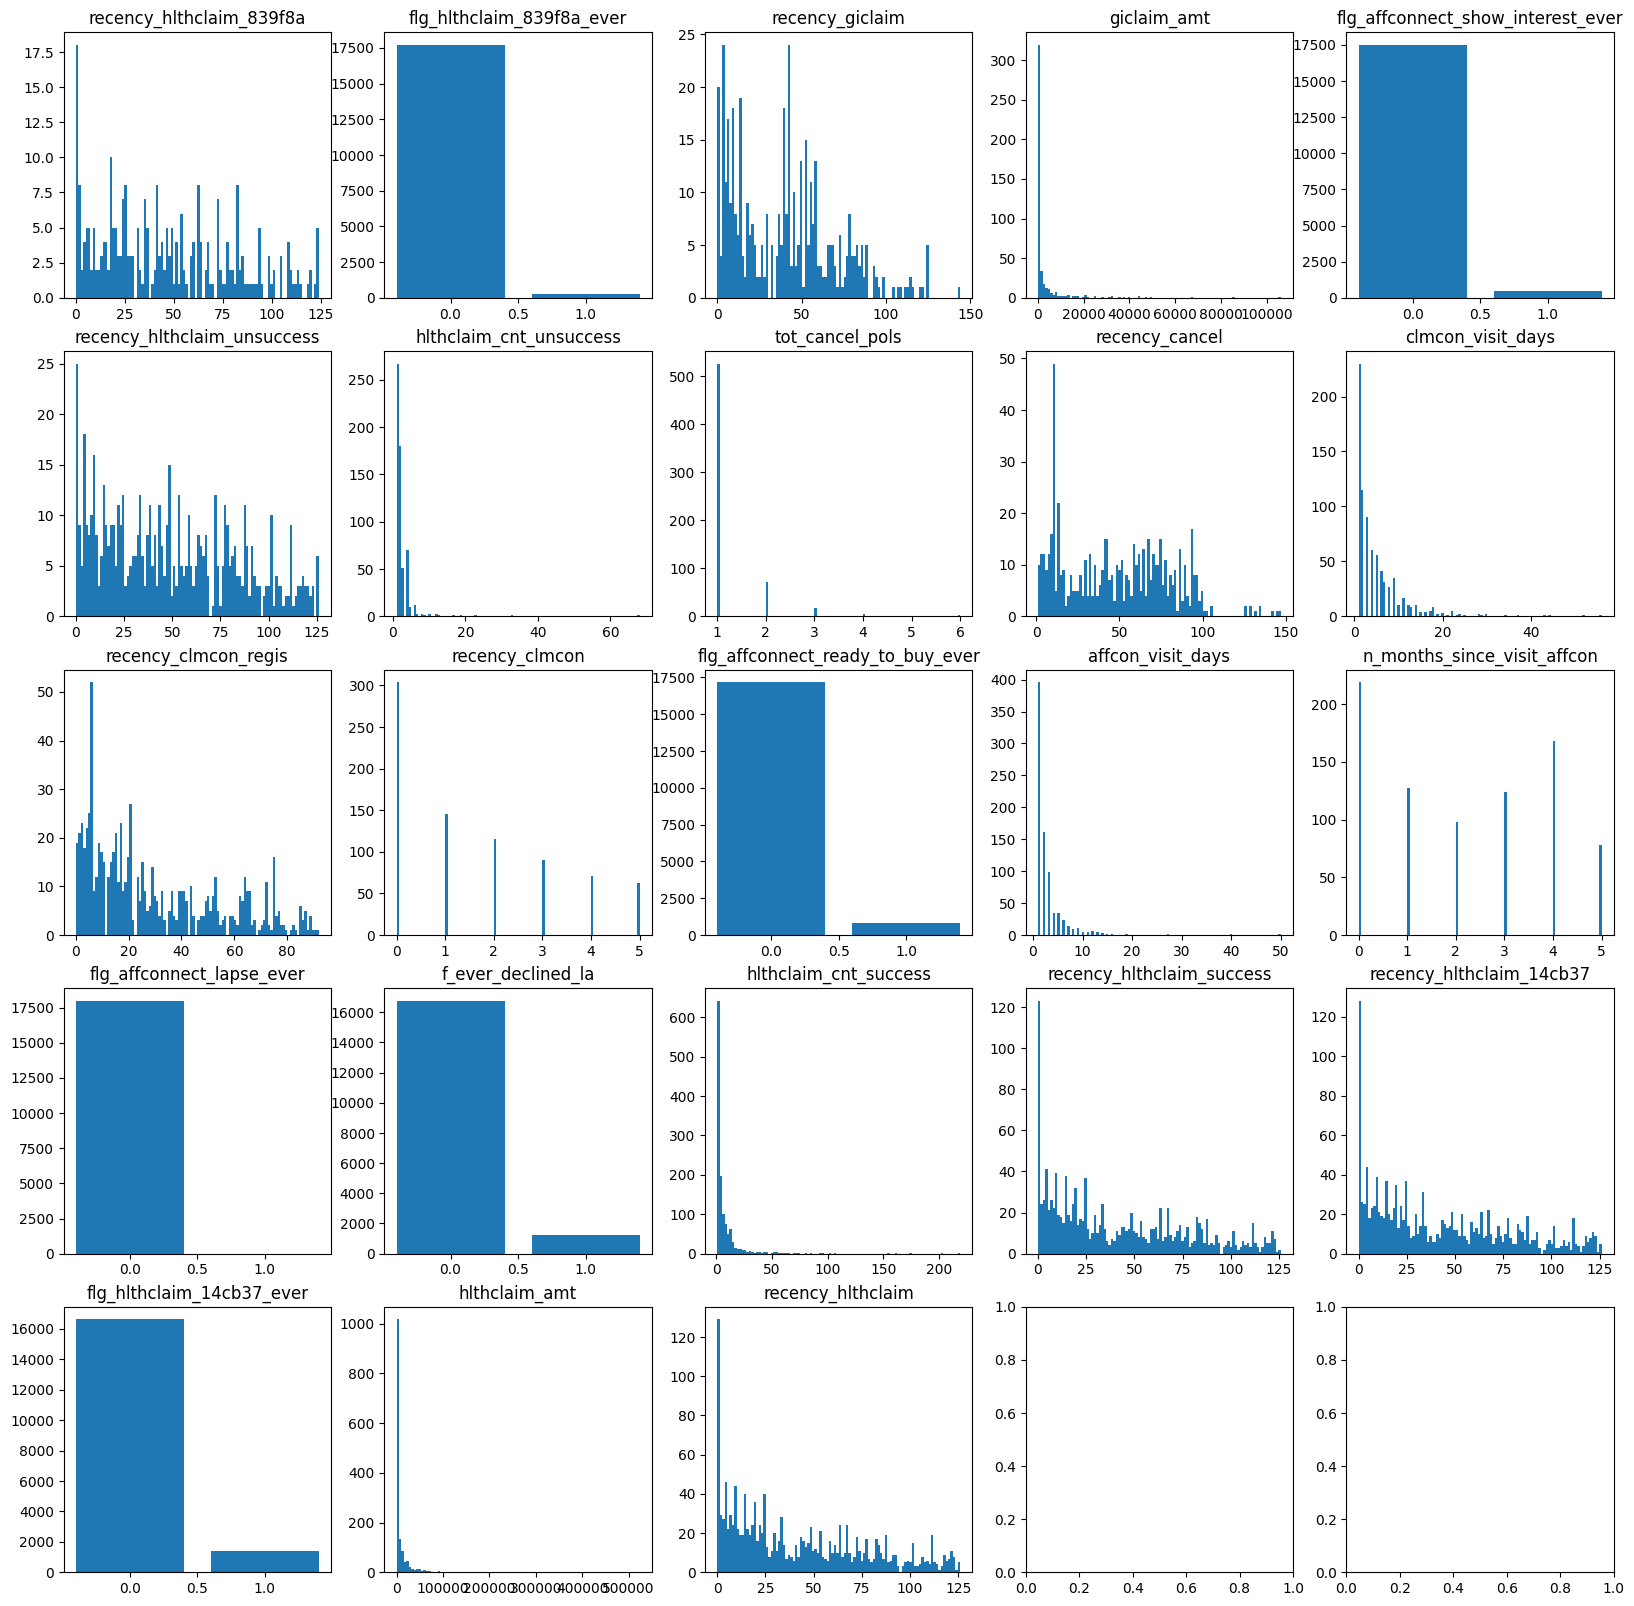

In [17]:
# Visualizing Distribution

n_rows = 5
n_cols = len(columns_90) // n_rows + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for i in range(len(columns_90)):
    col = columns_90[i]
    x = data_cleaned_v2[col].values

    if x.dtype == np.float64:
        axs[i//5, i%5].hist(x, bins=100)
        axs[i//5, i%5].set_title(col)

    else:
        axs[i//5, i%5].bar([0,1], [len(x)-x.sum(), x.sum()])
        axs[i//5, i%5].set_title(col)

All of them are skewed towards 0 so we can set null values as 0 in this case

In [18]:
data_cleaned_v2[columns_90] = data_cleaned_v2[columns_90].fillna(0.0)

##### Investigating Columns Containing "lapse"

n_months_since_lapse_grp_6a5788 n_months_since_lapse_grp_1581d7  \
19550                            9999                            9999   
4600                             9999                            9999   
13337                             NaN                             NaN   
15074                             NaN                             NaN   
19724                             NaN                             NaN   

      n_months_since_lapse_lh_d0adeb n_months_since_lapse_grp_9cdedf  \
19550                           9999                            9999   
4600                            9999                            9999   
13337                            NaN                             NaN   
15074                            NaN                             NaN   
19724                            NaN                             NaN   

      n_months_since_lapse_ltc_43b9d5 n_months_since_lapse_grp_de05ae  \
19550                            9999                            9999   
4600                             9999                            9999   
13337                             NaN                             NaN   
15074                             NaN                             NaN   
19724                             NaN                             NaN   

      n_months_since_lapse_grp_945b5a n_months_since_lapse_inv_dcd836  \
19550                            9999                            9999   
4600                             9999                            9999   
13337                             NaN                             NaN   
15074                             NaN                             NaN   
19724                             NaN                             NaN   

      n_months_since_lapse_grp_6fc3e6 n_months_since_lapse_ltc_1280bf  ...  \
19550                            9999                            9999  ...   
4600                             9999                            9999  ...   
13337                             NaN                             NaN  ...   
15074                             NaN                             NaN  ...   
19724                             NaN                             NaN  ...   

      lapse_ape_grp_22decf lapse_ape_lh_507c37 lapse_ape_lh_839f8a  \
19550                 0.00                0.00                0.00   
4600                  0.00                0.00                0.00   
13337                  NaN                 NaN                 NaN   
15074                  NaN                 NaN                 NaN   
19724                  NaN                 NaN                 NaN   

      lapse_ape_inv_e9f316 lapse_ape_grp_caa6ff lapse_ape_grp_fd3bfb  \
19550                 0.00                 0.00                 0.00   
4600                  0.00                 0.00                 0.00   
13337                  NaN                  NaN                  NaN   
15074                  NaN                  NaN                  NaN   
19724                  NaN                  NaN                  NaN   

      lapse_ape_lh_e22a6a lapse_ape_grp_70e1dd lapse_ape_grp_e04c3a  \
19550                0.00                 0.00                 0.00   
4600               601.00                 0.00                 0.00   
13337                 NaN                  NaN                  NaN   
15074                 NaN                  NaN                  NaN   
19724                 NaN                  NaN                  NaN   

      lapse_ape_ltc_1280bf  
19550                 0.00  
4600                  0.00  
13337                  NaN  
15074                  NaN  
19724                  NaN  

[5 rows x 50 columns]

<Axes: >

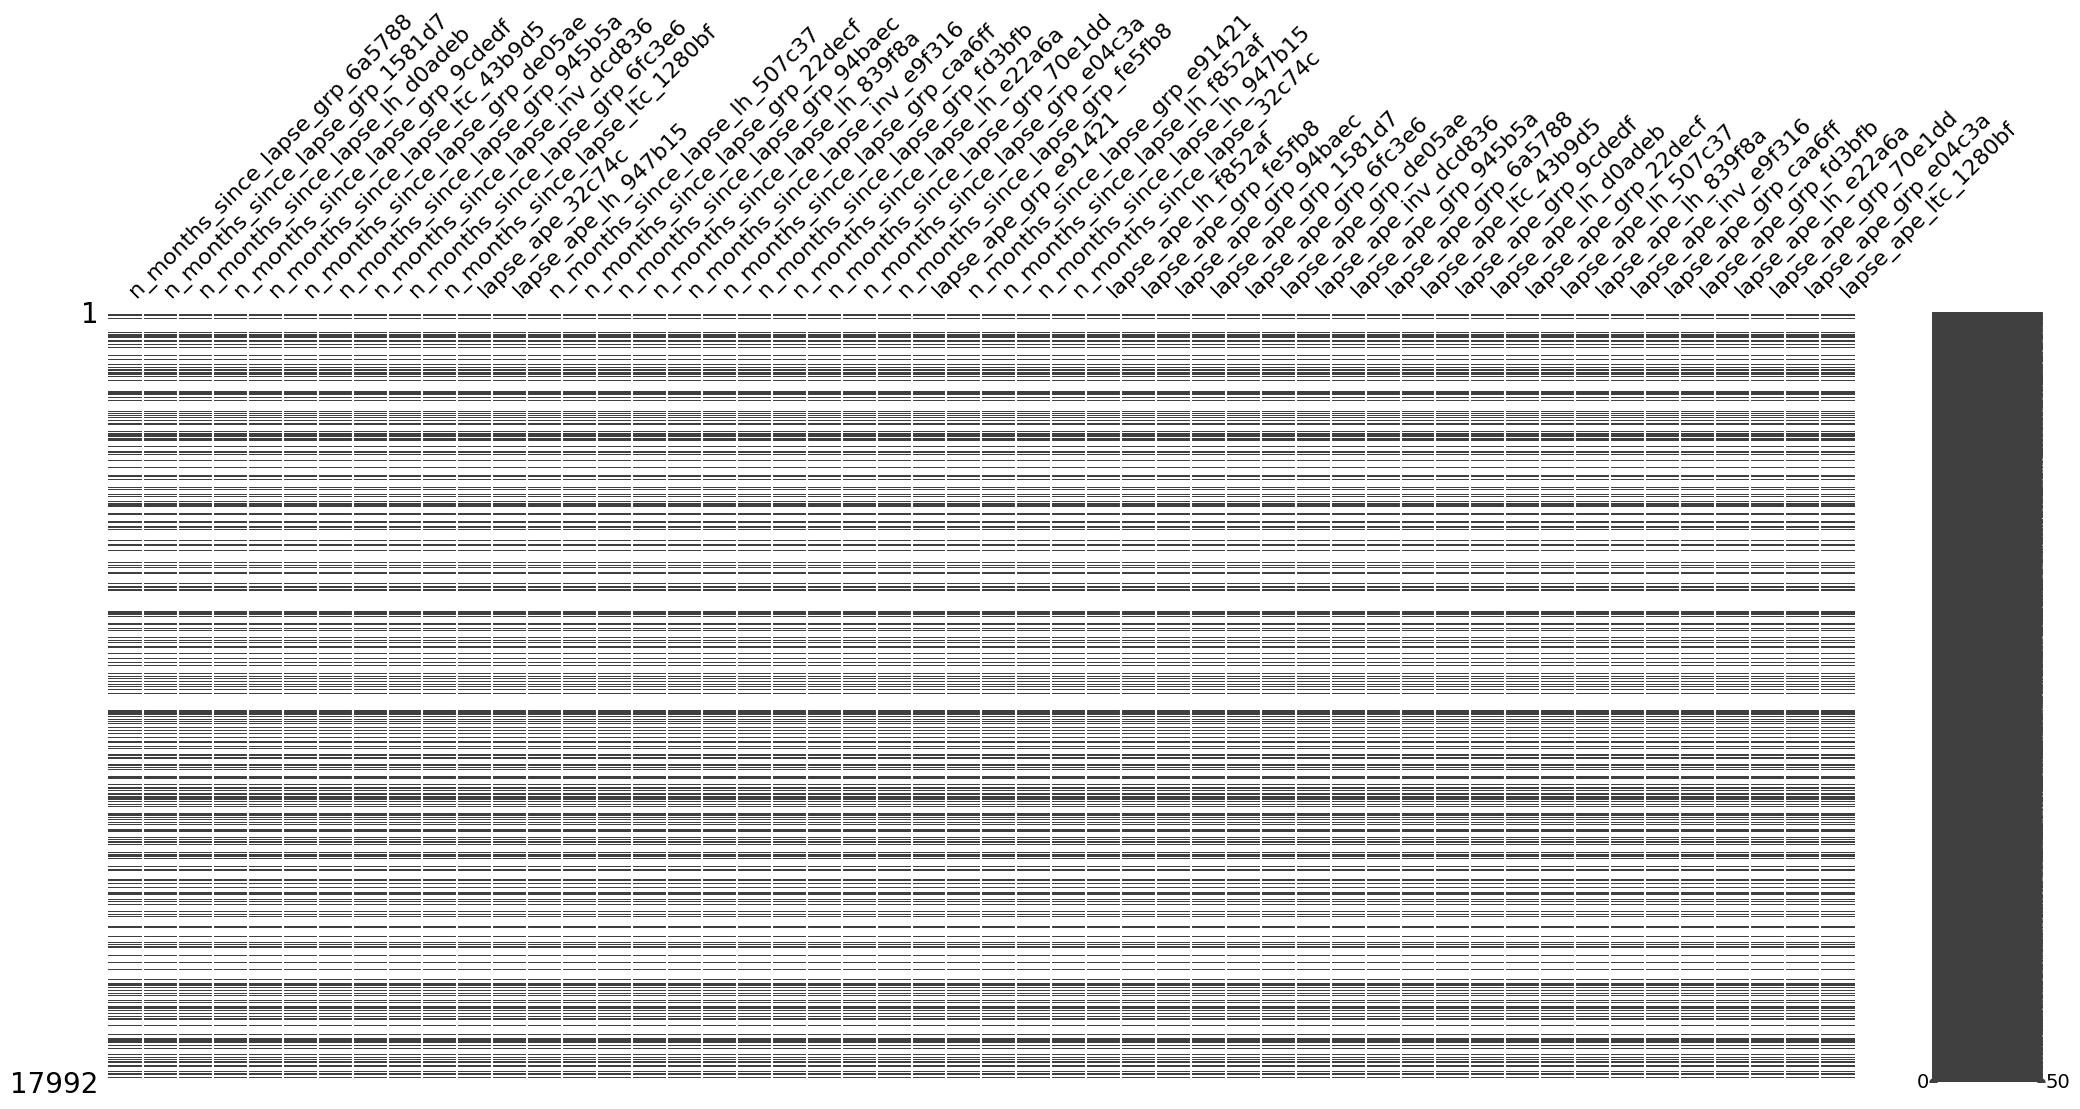

In [19]:
# Check whether the indexes of null overlaps
lapse_c = nan_df_v1[nan_df_v1["% of Total Values"] == 70].index.values
lapse_columns = []

for c in lapse_c:
    if c != "recency_lapse":
        lapse_columns.append(c)

lapse_data = data_cleaned_v2[lapse_columns]

display(lapse_data.head())
msno.matrix(lapse_data)

In [20]:
lapse_data.dtypes

n_months_since_lapse_grp_6a5788    object
n_months_since_lapse_grp_1581d7    object
n_months_since_lapse_lh_d0adeb     object
n_months_since_lapse_grp_9cdedf    object
n_months_since_lapse_ltc_43b9d5    object
n_months_since_lapse_grp_de05ae    object
n_months_since_lapse_grp_945b5a    object
n_months_since_lapse_inv_dcd836    object
n_months_since_lapse_grp_6fc3e6    object
n_months_since_lapse_ltc_1280bf    object
lapse_ape_32c74c                   object
lapse_ape_lh_947b15                object
n_months_since_lapse_lh_507c37     object
n_months_since_lapse_grp_22decf    object
n_months_since_lapse_grp_94baec    object
n_months_since_lapse_lh_839f8a     object
n_months_since_lapse_inv_e9f316    object
n_months_since_lapse_grp_caa6ff    object
n_months_since_lapse_grp_fd3bfb    object
n_months_since_lapse_lh_e22a6a     object
n_months_since_lapse_grp_70e1dd    object
n_months_since_lapse_grp_e04c3a    object
n_months_since_lapse_grp_fe5fb8    object
lapse_ape_grp_e91421              

In [21]:
data_cleaned_v2[lapse_columns] = data_cleaned_v2[lapse_columns].astype(np.float64)

In [22]:
data_cleaned_v2[lapse_columns].describe()

n_months_since_lapse_grp_6a5788  n_months_since_lapse_grp_1581d7  \
count                      5400.000000                      5400.000000   
mean                       9921.297963                      9014.721667   
std                         877.721029                      2971.501933   
min                         -53.000000                       -53.000000   
25%                        9999.000000                      9999.000000   
50%                        9999.000000                      9999.000000   
75%                        9999.000000                      9999.000000   
max                        9999.000000                      9999.000000   

       n_months_since_lapse_lh_d0adeb  n_months_since_lapse_grp_9cdedf  \
count                          5400.0                      5400.000000   
mean                           9999.0                      9866.004259   
std                               0.0                      1144.189504   
min                            9999.0                       -53.000000   
25%                            9999.0                      9999.000000   
50%                            9999.0                      9999.000000   
75%                            9999.0                      9999.000000   
max                            9999.0                      9999.000000   

       n_months_since_lapse_ltc_43b9d5  n_months_since_lapse_grp_de05ae  \
count                      5400.000000                      5400.000000   
mean                       9854.705000                      9987.871667   
std                        1192.014978                       333.700093   
min                           1.000000                       -53.000000   
25%                        9999.000000                      9999.000000   
50%                        9999.000000                      9999.000000   
75%                        9999.000000                      9999.000000   
max                        9999.000000                      9999.000000   

       n_months_since_lapse_grp_945b5a  n_months_since_lapse_inv_dcd836  \
count                      5400.000000                           5400.0   
mean                       9612.589444                           9999.0   
std                        1925.956323                              0.0   
min                         -53.000000                           9999.0   
25%                        9999.000000                           9999.0   
50%                        9999.000000                           9999.0   
75%                        9999.000000                           9999.0   
max                        9999.000000                           9999.0   

       n_months_since_lapse_grp_6fc3e6  n_months_since_lapse_ltc_1280bf  ...  \
count                      5400.000000                           5400.0  ...   
mean                       9906.643148                           9999.0  ...   
std                         955.445455                              0.0  ...   
min                         -53.000000                           9999.0  ...   
25%                        9999.000000                           9999.0  ...   
50%                        9999.000000                           9999.0  ...   
75%                        9999.000000                           9999.0  ...   
max                        9999.000000                           9999.0  ...   

       lapse_ape_grp_22decf  lapse_ape_lh_507c37  lapse_ape_lh_839f8a  \
count           5400.000000          5400.000000          5400.000000   
mean               7.372981           129.828287            31.673607   
std              134.538384           644.735101           362.616540   
min                0.000000             0.000000             0.000000   
25%                0.000000             0.000000             0.000000   
50%                0.000000             0.000000             0.000000   
75%                0.000000             0.000000             0.000000   
max    

We can see that the lapse columns are extremely noisy and contains uninterpretable numbers such as 9999, thus we can drop them.

In [23]:
data_cleaned_v3 = data_cleaned_v2.drop(columns=lapse_columns)
data_cleaned_v3["recency_lapse"] = data_cleaned_v3["recency_lapse"].fillna(0.0)

##### Investigating Columns Containing 5.6% missing values

is_dependent_in_at_least_1_policy  flg_substandard  \
19550                                0.0              0.0   
4600                                 0.0              0.0   
13337                                0.0              0.0   
15074                                0.0              0.0   
19724                                0.0              0.0   

       flg_is_borderline_standard  flg_is_revised_term  flg_is_rental_flat  \
19550                         0.0                  0.0                 0.0   
4600                          0.0                  0.0                 0.0   
13337                         0.0                  0.0                 0.0   
15074                         0.0                  0.0                 0.0   
19724                         0.0                  0.0                 0.0   

       flg_has_health_claim  flg_has_life_claim  flg_gi_claim  \
19550                   0.0                 0.0           0.0   
4600                    0.0                 0.0           0.0   
13337                   0.0                 0.0           0.0   
15074                   0.0                 0.0           0.0   
19724                   0.0                 0.0           0.0   

       flg_is_proposal  flg_with_preauthorisation  flg_is_returned_mail  \
19550              0.0                        0.0                   0.0   
4600               0.0                        0.0                   0.0   
13337              0.0                        0.0                   0.0   
15074              0.0                        0.0                   0.0   
19724              0.0                        0.0                   0.0   

       is_consent_to_mail  is_consent_to_call  is_consent_to_sms  is_valid_dm  \
19550                 0.0                 0.0                0.0          1.0   
4600                  0.0                 0.0                0.0          1.0   
13337                 1.0                 0.0                0.0          1.0   
15074                 0.0                 0.0                0.0          1.0   
19724                 1.0                 0.0                1.0          1.0   

       is_valid_email  is_housewife_retiree  is_sg_pr  is_class_1_2  \
19550             1.0                   0.0       1.0           1.0   
4600              0.0                   0.0       1.0           0.0   
13337             1.0                   0.0       1.0           1.0   
15074             1.0                   0.0       1.0           1.0   
19724             1.0                   0.0       1.0           1.0   

       is_consent_to_email  
19550                  0.0  
4600                   0.0  
13337                  1.0  
15074                  0.0  
19724                  1.0

<Axes: >

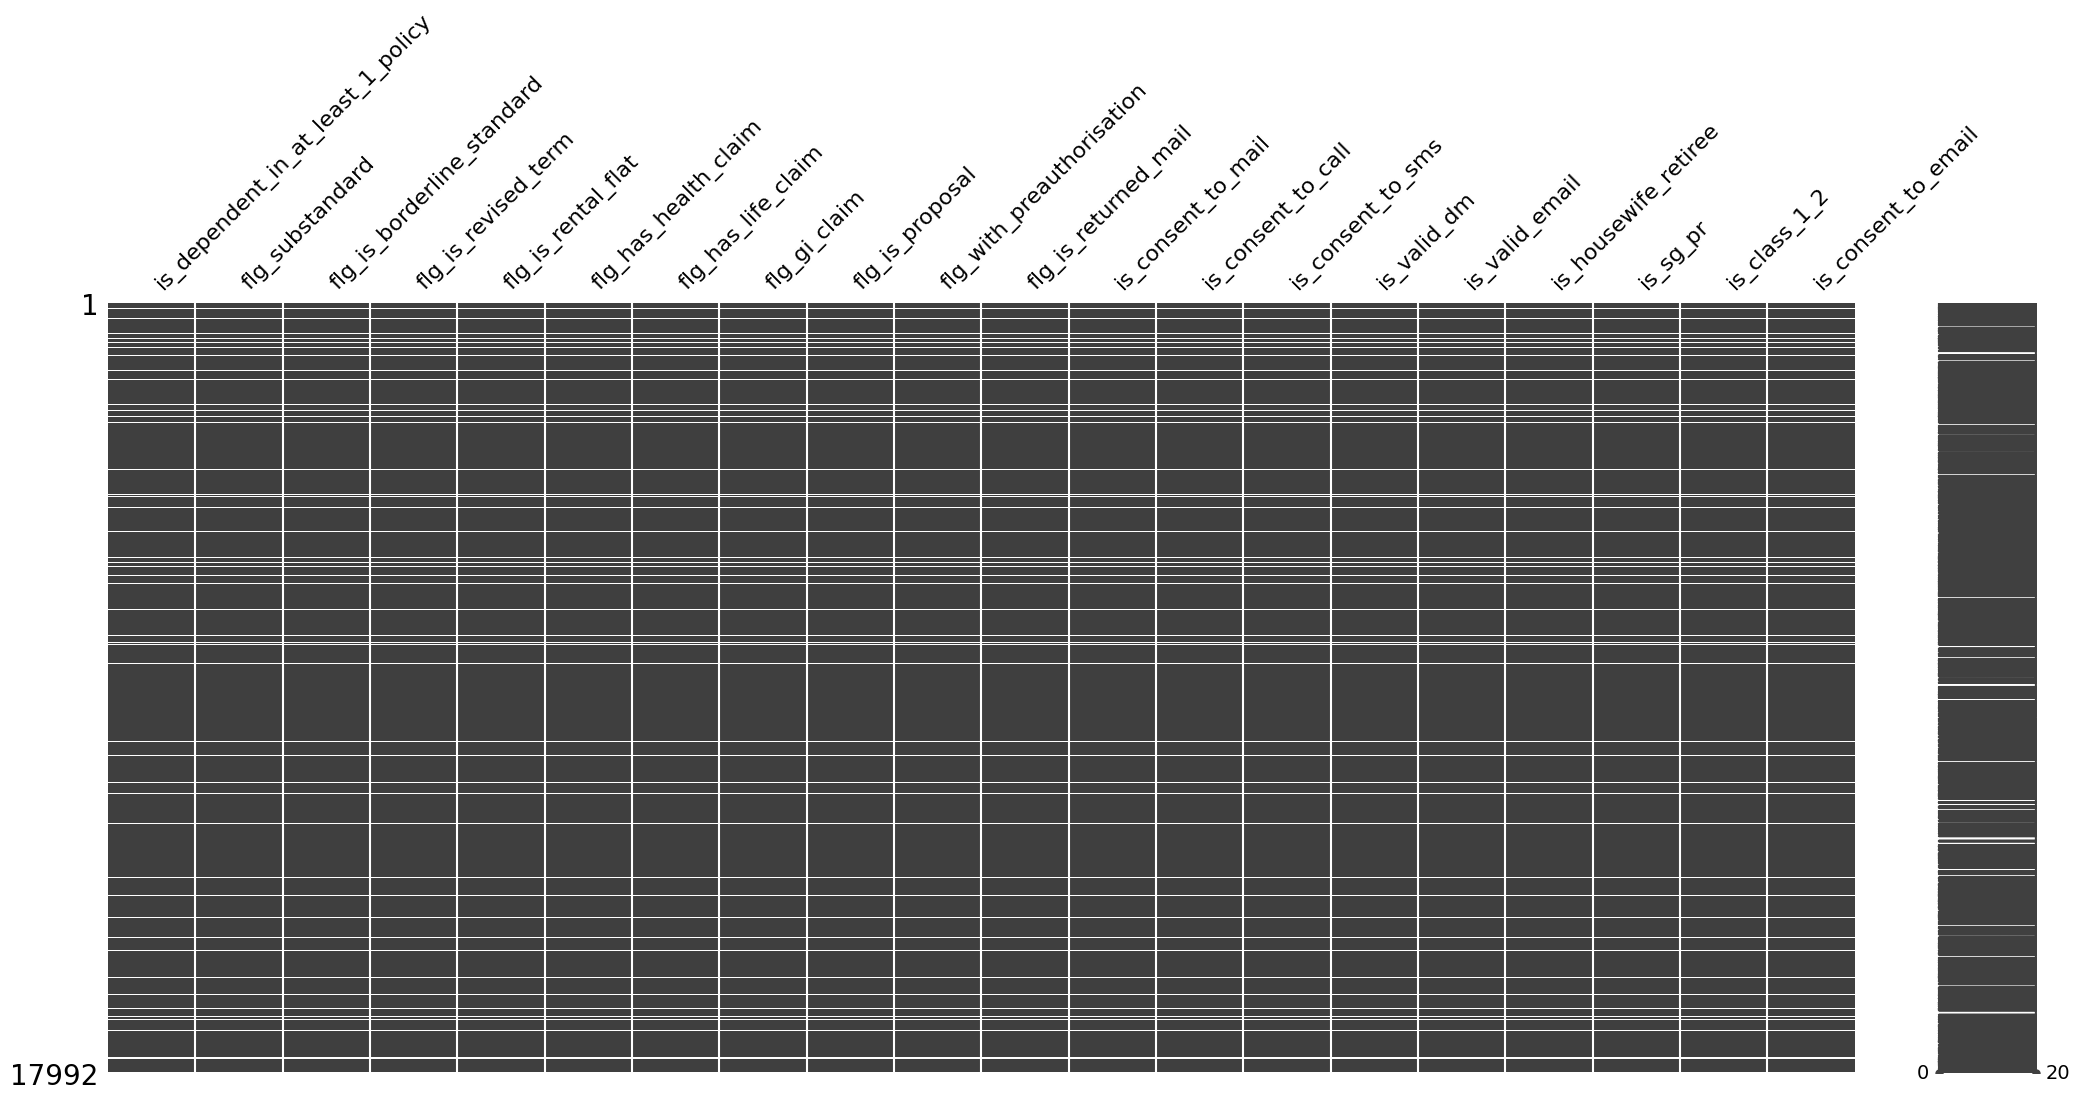

In [24]:
_columns = nan_df_v1[nan_df_v1["% of Total Values"] == 5.6].index.values

_columns_data = data_cleaned_v3[_columns]

display(_columns_data.head())
msno.matrix(_columns_data)

In [25]:
data_cleaned_v3[_columns].describe()

is_dependent_in_at_least_1_policy  flg_substandard  \
count                            16978.0     16978.000000   
mean                                 0.0         0.040287   
std                                  0.0         0.196638   
min                                  0.0         0.000000   
25%                                  0.0         0.000000   
50%                                  0.0         0.000000   
75%                                  0.0         0.000000   
max                                  0.0         1.000000   

       flg_is_borderline_standard  flg_is_revised_term  flg_is_rental_flat  \
count                16978.000000         16978.000000        16978.000000   
mean                     0.033102             0.000707            0.012546   
std                      0.178907             0.026577            0.111306   
min                      0.000000             0.000000            0.000000   
25%                      0.000000             0.000000            0.000000   
50%                      0.000000             0.000000            0.000000   
75%                      0.000000             0.000000            0.000000   
max                      1.000000             1.000000            1.000000   

       flg_has_health_claim  flg_has_life_claim  flg_gi_claim  \
count          16978.000000        16978.000000  16978.000000   
mean               0.048769            0.003593      0.033278   
std                0.215391            0.059835      0.179368   
min                0.000000            0.000000      0.000000   
25%                0.000000            0.000000      0.000000   
50%                0.000000            0.000000      0.000000   
75%                0.000000            0.000000      0.000000   
max                1.000000            1.000000      1.000000   

       flg_is_proposal  flg_with_preauthorisation  flg_is_returned_mail  \
count     16978.000000               16978.000000          16978.000000   
mean          0.002886                   0.008246              0.019260   
std           0.053646                   0.090435              0.137442   
min           0.000000                   0.000000              0.000000   
25%           0.000000                   0.000000              0.000000   
50%           0.000000                   0.000000              0.000000   
75%           0.000000                   0.000000              0.000000   
max           1.000000                   1.000000              1.000000   

       is_consent_to_mail  is_consent_to_call  is_consent_to_sms  \
count        16978.000000        16978.000000       16978.000000   
mean             0.321769            0.119154           0.254035   
std              0.467169            0.323979           0.435330   
min              0.000000            0.000000           0.000000   
25%              0.000000            0.000000           0.000000   
50%              0.000000            0.000000           0.000000   
75%              1.000000            0.000000           1.000000   
max              1.000000            1.000000           1.000000   

        is_valid_dm  is_valid_email  is_housewife_retiree      is_sg_pr  \
count  16978.000000    16978.000000          16978.000000  16978.000000   
mean       0.713806        0.743433              0.003181      0.918424   
std        0.451994        0.436751              0.056309      0.273726   
min        0.000000        0.000000              0.000000      0.000000   
25%        0.000000        0.000000              0.000000      1.000000   
50%        1.000000        1.000000              0.000000      1.000000   
75%        1.000000        1.000000              0.000000      1.000000   
max        1.000000        1.000000              1.000000      1.000000   

       is_class_1_2  is_consent_to_email  
count  16978.000000         16978.000000  
mean       0.533102             0.382966  
std        0.498918             0.486124  
min        0.000000            

In [26]:
data_cleaned_v3[_columns].dtypes

is_dependent_in_at_least_1_policy    float64
flg_substandard                      float64
flg_is_borderline_standard           float64
flg_is_revised_term                  float64
flg_is_rental_flat                   float64
flg_has_health_claim                 float64
flg_has_life_claim                   float64
flg_gi_claim                         float64
flg_is_proposal                      float64
flg_with_preauthorisation            float64
flg_is_returned_mail                 float64
is_consent_to_mail                   float64
is_consent_to_call                   float64
is_consent_to_sms                    float64
is_valid_dm                          float64
is_valid_email                       float64
is_housewife_retiree                 float64
is_sg_pr                             float64
is_class_1_2                         float64
is_consent_to_email                  float64
dtype: object

In [27]:
data_cleaned_v3[_columns] = data_cleaned_v3[_columns].fillna(0.0).astype(np.int8)

data_cleaned_v3.dtypes

clntnum                       object
race_desc                     object
ctrycode_desc                 object
clttype                       object
stat_flag                     object
                              ...   
flg_hlthclaim_14cb37_ever       int8
recency_hlthclaim_14cb37     float64
giclaim_amt                  float64
recency_giclaim              float64
f_purchase_lh                float64
Length: 246, dtype: object

In [28]:
data_cleaned_v3.head()

clntnum race_desc ctrycode_desc clttype stat_flag min_occ_date  \
19550  91b546e924   Chinese     Singapore       P    ACTIVE   2017-10-31   
4600   896bae548c   Chinese     Singapore       P    ACTIVE   2007-05-23   
13337  f364439ae6    Others     Singapore       P    ACTIVE   2019-08-31   
15074  70f319cfe1   Chinese     Singapore       P    ACTIVE   2021-10-18   
19724  2647a81328   Chinese     Singapore       P    ACTIVE   2018-07-20   

       cltdob_fix cltsex_fix  flg_substandard  flg_is_borderline_standard  \
19550  1974-05-09     Female                0                           0   
4600   1979-11-11       Male                0                           0   
13337  1976-01-28       Male                0                           0   
15074  1976-03-19     Female                0                           0   
19724  1995-07-31     Female                0                           0   

       ...  recency_hlthclaim_success  hlthclaim_cnt_unsuccess  \
19550  ...                        0.0                      0.0   
4600   ...                        0.0                      0.0   
13337  ...                        0.0                      0.0   
15074  ...                        0.0                      0.0   
19724  ...                        0.0                      0.0   

       recency_hlthclaim_unsuccess  flg_hlthclaim_839f8a_ever  \
19550                          0.0                          0   
4600                           0.0                          0   
13337                          0.0                          0   
15074                          0.0                          0   
19724                          0.0                          0   

       recency_hlthclaim_839f8a  flg_hlthclaim_14cb37_ever  \
19550                       0.0                          0   
4600                        0.0                          0   
13337                       0.0                          0   
15074                       0.0                          0   
19724                       0.0                          0   

       recency_hlthclaim_14cb37  giclaim_amt  recency_giclaim  f_purchase_lh  
19550                       0.0          0.0              0.0            0.0  
4600                        0.0          0.0              0.0            0.0  
13337                       0.0          0.0              0.0            0.0  
15074                       0.0          0.0              0.0            0.0  
19724                       0.0          0.0              0.0            0.0  

[5 rows x 246 columns]

In [29]:
missing_values_table(data_cleaned_v3)

Your selected dataframe has 246 columns.
There are 8 columns that have missing values.


Missing Values  % of Total Values
race_desc                    3996               22.2
hh_20                        2809               15.6
pop_20                       2809               15.6
hh_size                      2809               15.6
hh_size_est                  2809               15.6
annual_income_est            2809               15.6
cltsex_fix                     23                0.1
ctrycode_desc                  20                0.1

We will replace null values in `race_desc`, `hh_size_est`and `annual_income_est` with a new category `"No Information"`, the rest will be dropped.

In [30]:
most_freq = SimpleImputer(strategy='constant', fill_value="No Information")
data_cleaned_v3 = data_cleaned_v3.drop(columns=["hh_20", "pop_20", "hh_size", "cltsex_fix", "ctrycode_desc"])
data_cleaned_v3[["race_desc", "hh_size_est", "annual_income_est"]] = most_freq.fit_transform(data_cleaned_v3[["race_desc", "hh_size_est", "annual_income_est"]])

### Load Data

In [31]:
data = data_cleaned_v3.drop(columns=["clntnum"]) # drop the id column

data.head()

race_desc clttype stat_flag min_occ_date  cltdob_fix  flg_substandard  \
19550   Chinese       P    ACTIVE   2017-10-31  1974-05-09                0   
4600    Chinese       P    ACTIVE   2007-05-23  1979-11-11                0   
13337    Others       P    ACTIVE   2019-08-31  1976-01-28                0   
15074   Chinese       P    ACTIVE   2021-10-18  1976-03-19                0   
19724   Chinese       P    ACTIVE   2018-07-20  1995-07-31                0   

       flg_is_borderline_standard  flg_is_revised_term  flg_is_rental_flat  \
19550                           0                    0                   0   
4600                            0                    0                   0   
13337                           0                    0                   0   
15074                           0                    0                   0   
19724                           0                    0                   0   

       flg_has_health_claim  ...  recency_hlthclaim_success  \
19550                     0  ...                        0.0   
4600                      0  ...                        0.0   
13337                     0  ...                        0.0   
15074                     0  ...                        0.0   
19724                     0  ...                        0.0   

       hlthclaim_cnt_unsuccess  recency_hlthclaim_unsuccess  \
19550                      0.0                          0.0   
4600                       0.0                          0.0   
13337                      0.0                          0.0   
15074                      0.0                          0.0   
19724                      0.0                          0.0   

       flg_hlthclaim_839f8a_ever  recency_hlthclaim_839f8a  \
19550                          0                       0.0   
4600                           0                       0.0   
13337                          0                       0.0   
15074                          0                       0.0   
19724                          0                       0.0   

       flg_hlthclaim_14cb37_ever  recency_hlthclaim_14cb37  giclaim_amt  \
19550                          0                       0.0          0.0   
4600                           0                       0.0          0.0   
13337                          0                       0.0          0.0   
15074                          0                       0.0          0.0   
19724                          0                       0.0          0.0   

       recency_giclaim  f_purchase_lh  
19550              0.0            0.0  
4600               0.0            0.0  
13337              0.0            0.0  
15074              0.0            0.0  
19724              0.0            0.0  

[5 rows x 240 columns]

### Data Analysis

##### Convert to Correct Datatype

In [32]:
np.unique(data.dtypes.values)

array([dtype('int8'), dtype('int64'), dtype('float64'), dtype('O')],
      dtype=object)

In [33]:
dates = ["min_occ_date", "cltdob_fix"]
categorical = ["race_desc", "clttype", "stat_flag", "hh_size_est", "annual_income_est"]

In [34]:
for col in data.columns.values:
    if col == "n_months_last_bought_products" or col == "tot_inforce_pols":
        data[col] = data[col].astype(np.float64)

    elif data[col].dtype == np.int64 or col == "f_purchase_lh":
        data[col] = data[col].astype(np.int8)

    elif data[col].dtype == np.dtype('O') and (col not in (dates + categorical)):
        data[col] = data[col].astype(np.float64)

##### Create age and insurance time columns

In [35]:
data["age"] = data.cltdob_fix.apply(lambda x: ((pd.Timestamp('now') - pd.to_datetime(x, format="%Y-%m-%d")) / pd.Timedelta('365 days')) if x != "None" else np.nan)
data["insurance_time"] = data.min_occ_date.apply(lambda x: ((pd.Timestamp('now') - pd.to_datetime(x, format="%Y-%m-%d")) / pd.Timedelta('365 days')) if x != "None" else np.nan)
data = data.drop(columns = dates)

<ipython-input-35-36f7457e5b33>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["age"] = data.cltdob_fix.apply(lambda x: ((pd.Timestamp('now') - pd.to_datetime(x, format="%Y-%m-%d")) / pd.Timedelta('365 days')) if x != "None" else np.nan)
<ipython-input-35-36f7457e5b33>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["insurance_time"] = data.min_occ_date.apply(lambda x: ((pd.Timestamp('now') - pd.to_datetime(x, format="%Y-%m-%d")) / pd.Timedelta('365 days')) if x != "None" else np.nan)


In [36]:
mean_imputer = SimpleImputer(strategy='mean') # impute using constant value
data[["age", "insurance_time"]] = mean_imputer.fit_transform(data[["age", "insurance_time"]])

##### Analyze Catgorical Columns

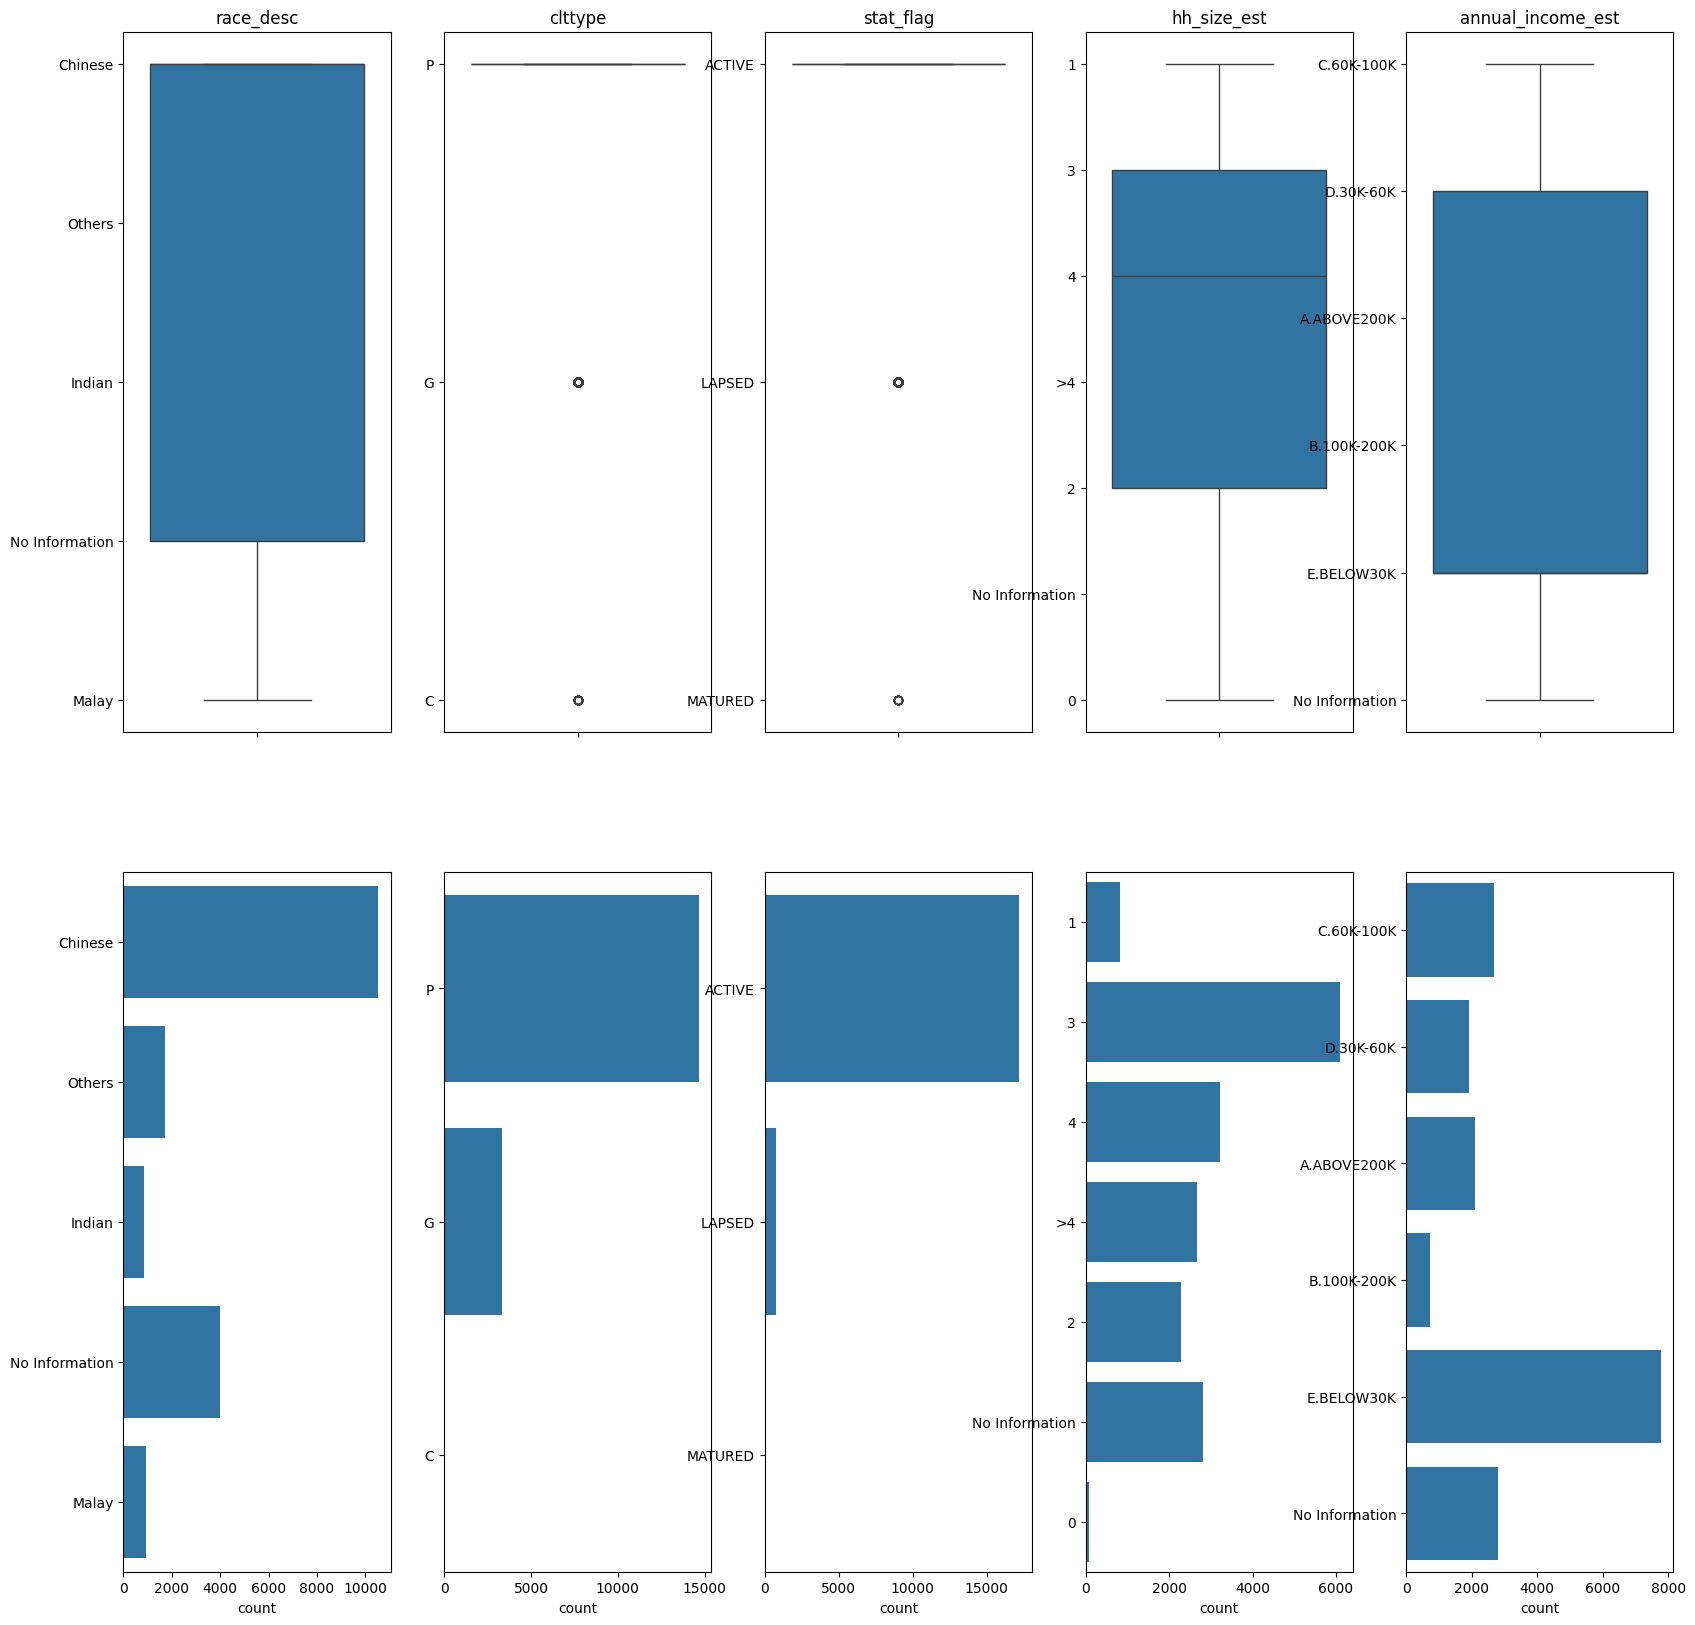

In [37]:
fig, axs = plt.subplots(2, len(categorical), figsize=(20, 20))
import seaborn as sns

for i in range(len(categorical)):
    col = categorical[i]
    axs[0, i].set_title(col)
    sns.boxplot(data[col].values, ax=axs[0, i])
    sns.countplot(data[col].values, ax=axs[1, i])

##### Analyze Numercial Columns

In [38]:
columns = data.columns.values

numercial_columns = []

for c in columns:
    if c not in categorical and data[c].values.dtype != np.int8:
        numercial_columns.append(c)

In [39]:
data[numercial_columns].describe()

n_months_last_bought_products  recency_lapse  recency_cancel  \
count                   17992.000000   17992.000000    17992.000000   
mean                       52.217708      23.108215        1.663517   
std                        62.545466      49.332467       10.544750   
min                        -4.000000       0.000000        0.000000   
25%                         8.000000       0.000000        0.000000   
50%                        31.000000       0.000000        0.000000   
75%                        75.000000      16.000000        0.000000   
max                       847.000000     489.000000      147.000000   

       tot_inforce_pols  tot_cancel_pols  ape_gi_42e115  ape_ltc_1280bf  \
count      17992.000000     17992.000000        17992.0         17992.0   
mean           2.506558         0.042241            0.0             0.0   
std            2.573982         0.248602            0.0             0.0   
min            1.000000         0.000000            0.0             0.0   
25%            1.000000         0.000000            0.0             0.0   
50%            2.000000         0.000000            0.0             0.0   
75%            3.000000         0.000000            0.0             0.0   
max           54.000000         6.000000            0.0             0.0   

       ape_grp_6fc3e6  ape_grp_de05ae  ape_inv_dcd836  ...  \
count    17992.000000    17992.000000         17992.0  ...   
mean         0.745315        0.173877             0.0  ...   
std          7.233422       12.094341             0.0  ...   
min          0.000000        0.000000             0.0  ...   
25%          0.000000        0.000000             0.0  ...   
50%          0.000000        0.000000             0.0  ...   
75%          0.000000        0.000000             0.0  ...   
max        270.000000     1274.400000             0.0  ...   

       hlthclaim_cnt_success  recency_hlthclaim_success  \
count           17992.000000               17992.000000   
mean                0.553802                   2.900789   
std                 4.709999                  14.051664   
min                 0.000000                   0.000000   
25%                 0.000000                   0.000000   
50%                 0.000000                   0.000000   
75%                 0.000000                   0.000000   
max               219.000000                 126.000000   

       hlthclaim_cnt_unsuccess  recency_hlthclaim_unsuccess  \
count             17992.000000                 17992.000000   
mean                  0.083259                     1.675189   
std                   0.812103                    11.012501   
min                   0.000000                     0.000000   
25%                   0.000000                     0.000000   
50%                   0.000000                     0.000000   
75%                   0.000000                     0.000000   
max                  68.000000                   126.000000   

       recency_hlthclaim_839f8a  recency_hlthclaim_14cb37    giclaim_amt  \
count              17992.000000              17992.000000   17992.000000   
mean                   0.729880                  3.223210      80.987125   
std                    7.187397                 14.902066    1624.665371   
min                    0.000000                  0.000000       0.000000   
25%                    0.000000                  0.000000       0.000000   
50%                    0.000000                  0.000000       0.000000   
75%                    0.000000                  0.000000       0.000000   
max                  124.000000                126.000000  106200.000000   

       recency_giclaim           age  insurance_time  
count     17992.000000  17992.000000    17992.000000  
mean          0.995943     45.185952        8.898546  
std           7.854963     12.395266        7.079121  
min           0.000000      9.834249        0.508221  
25%           0.000000     35.289043        3.182194  
50%           0.0

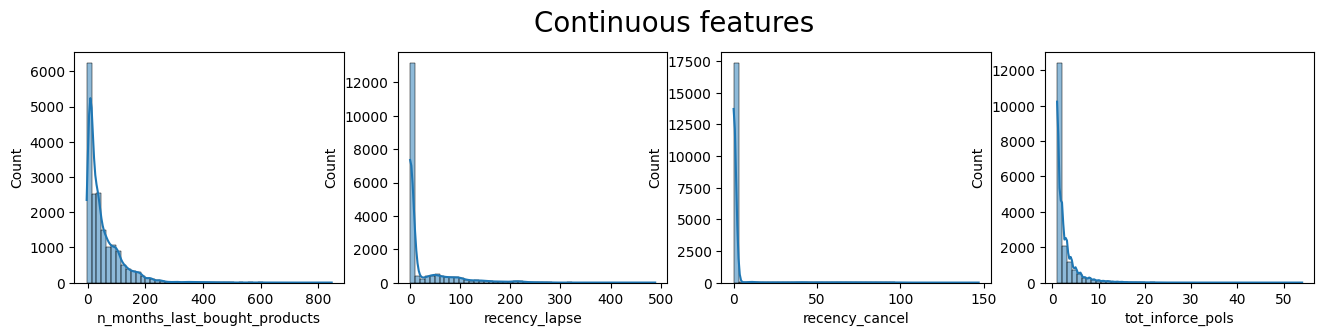

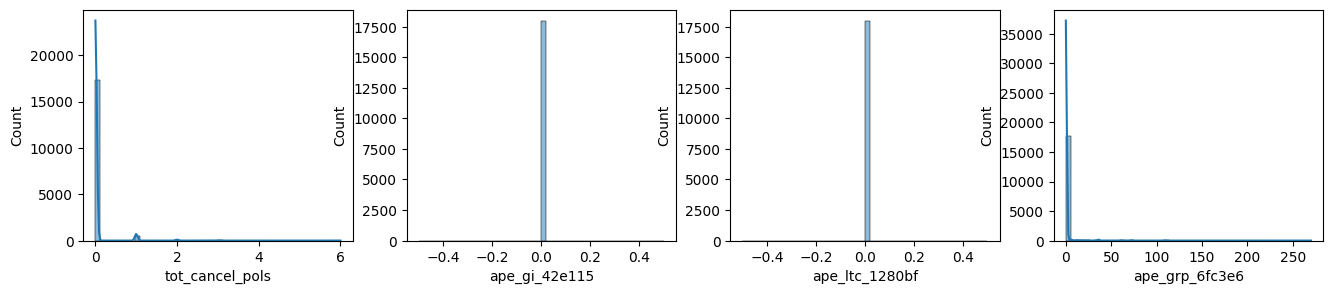

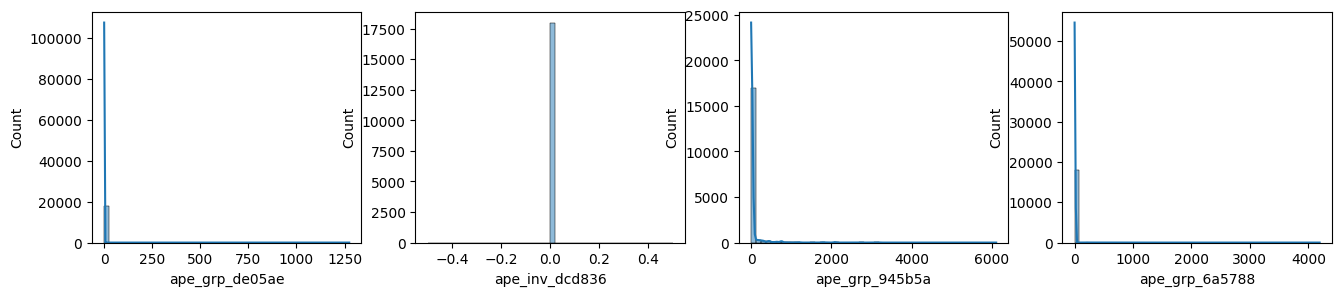

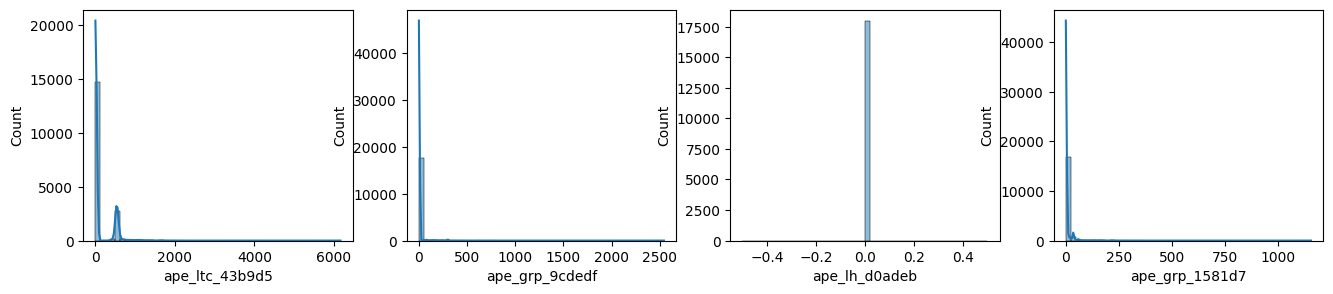

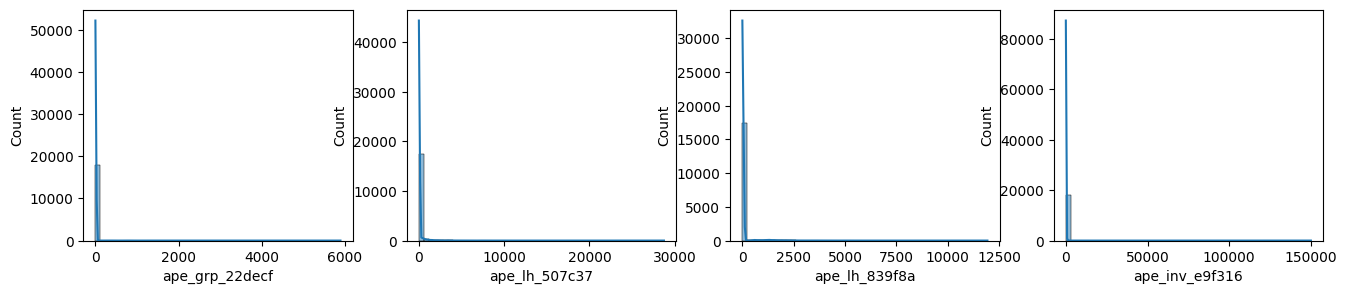

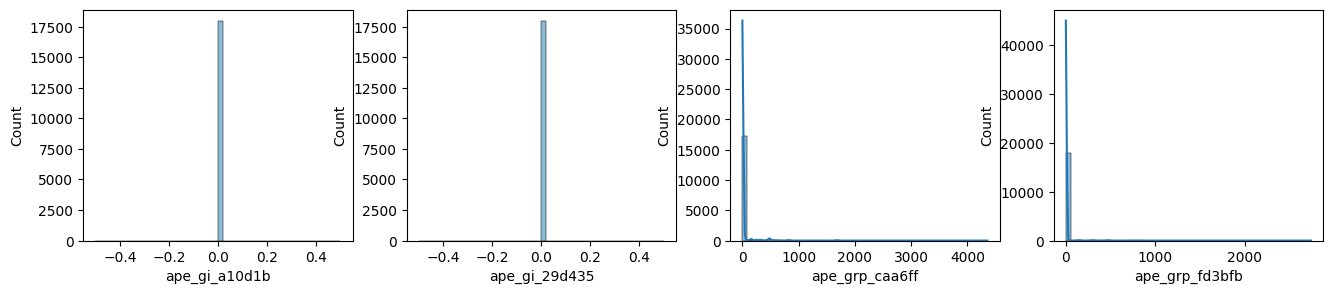

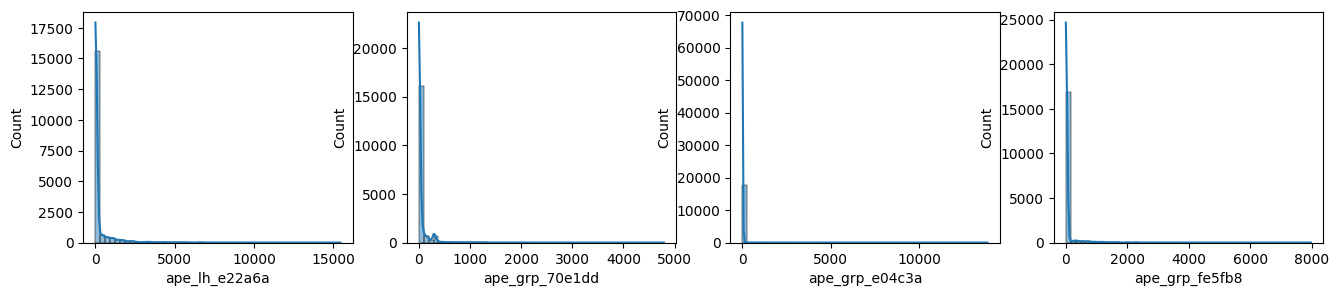

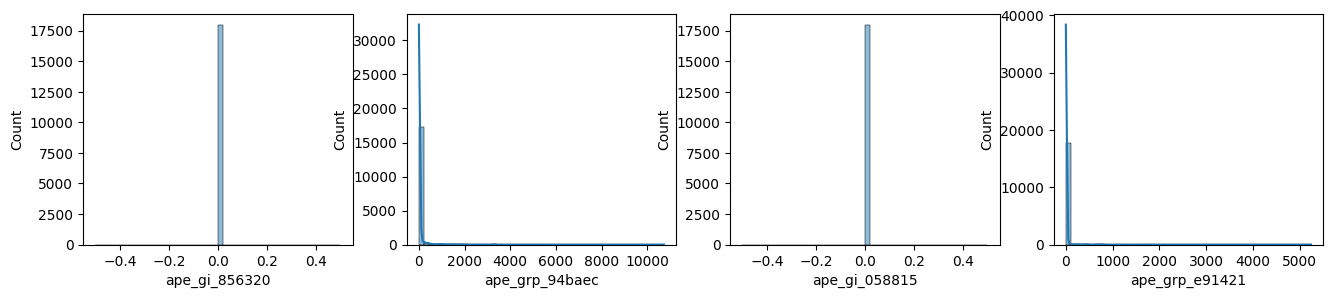

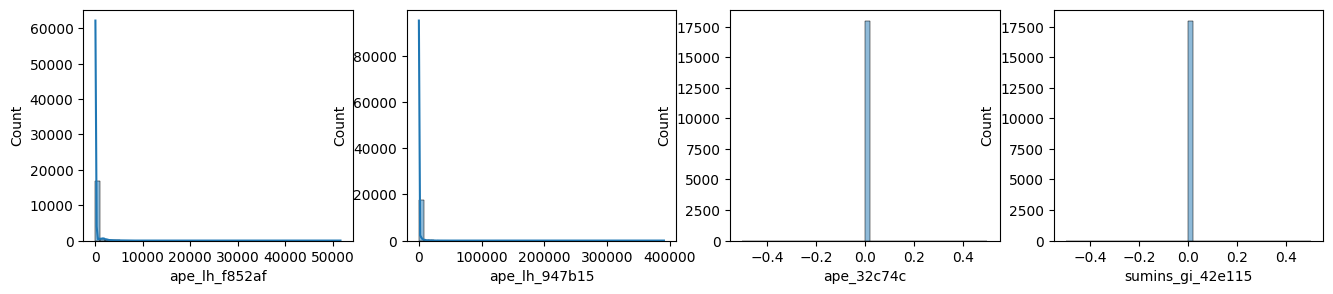

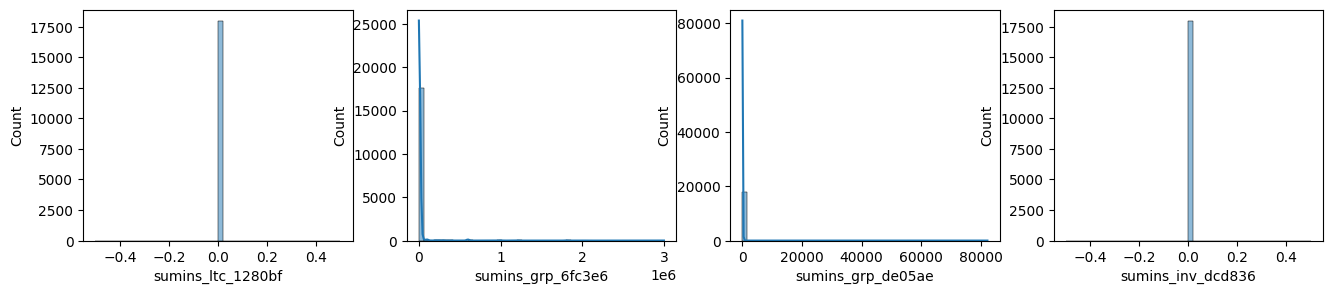

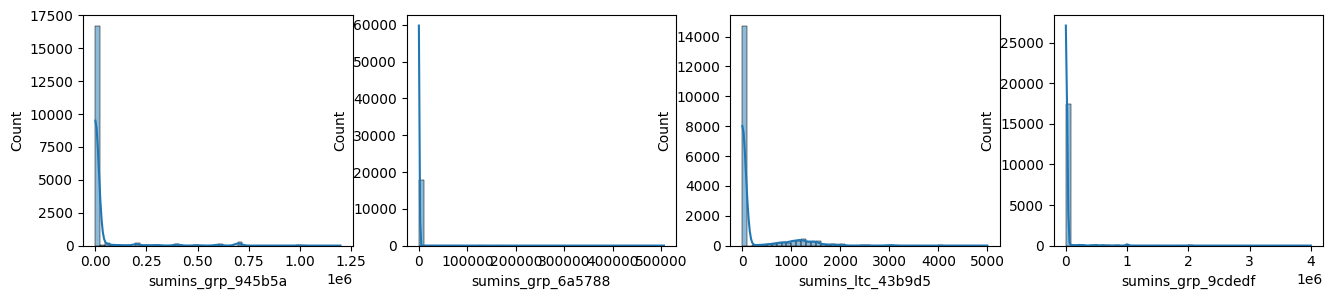

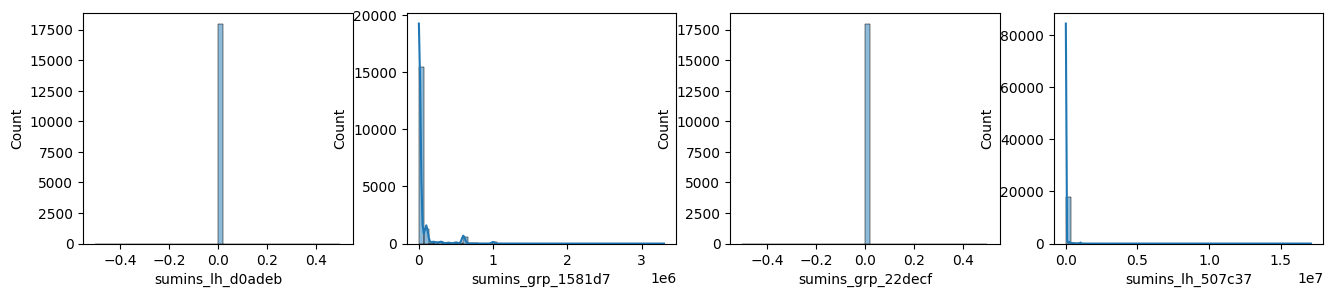

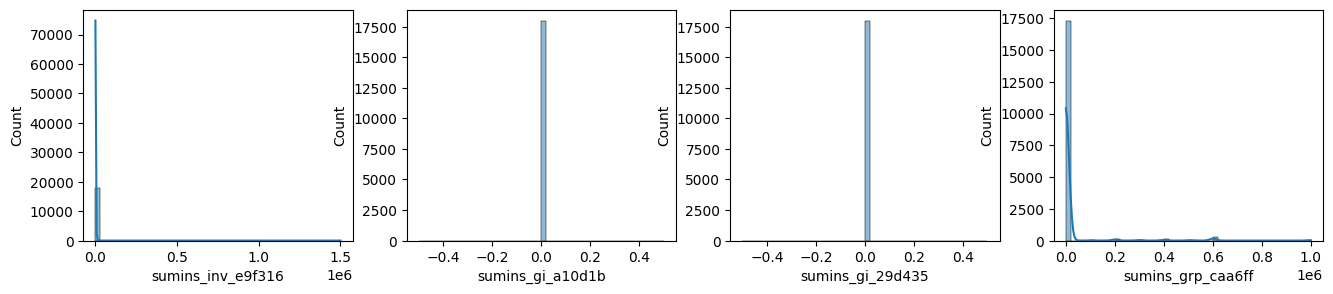

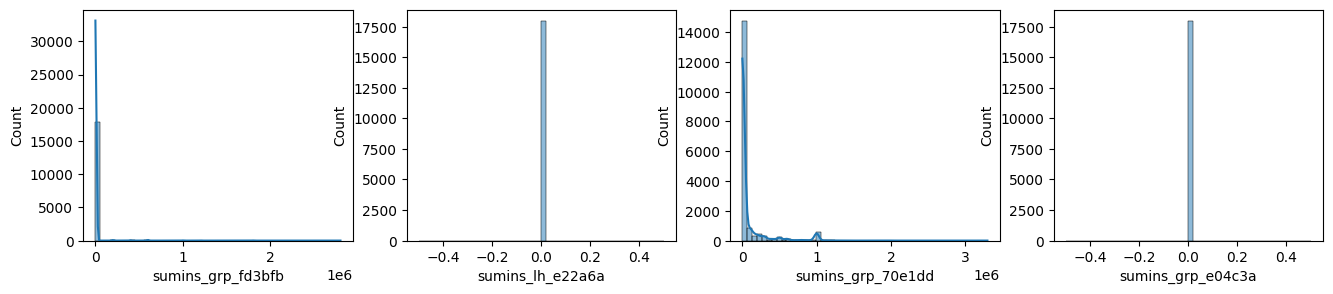

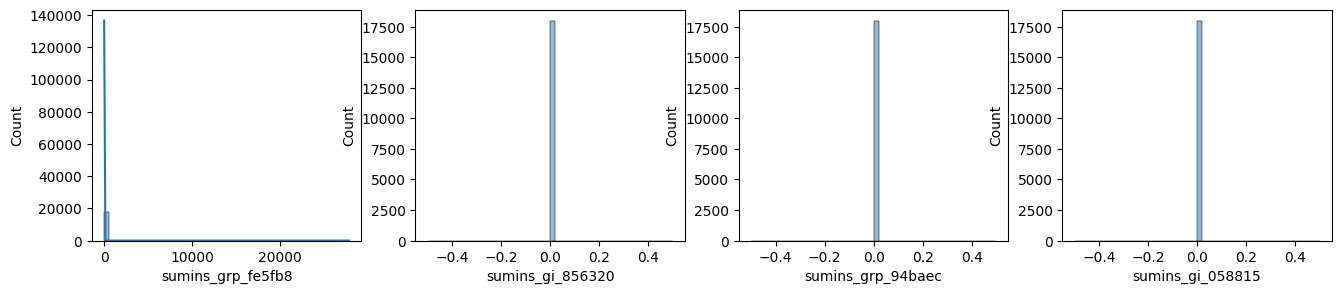

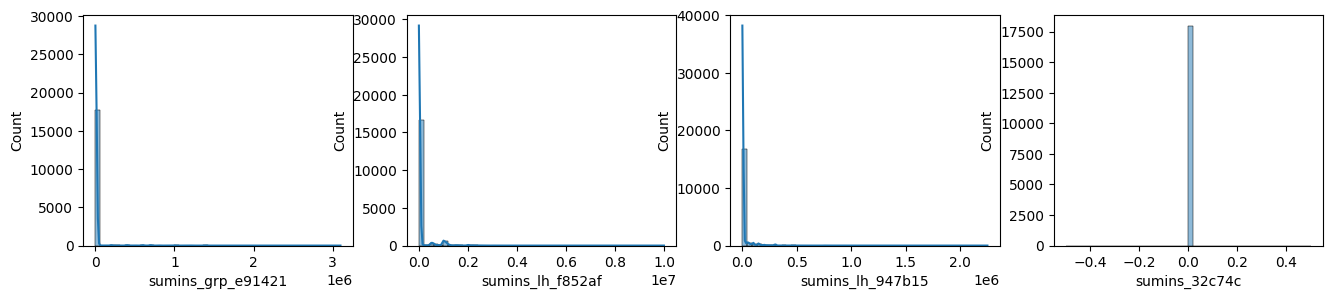

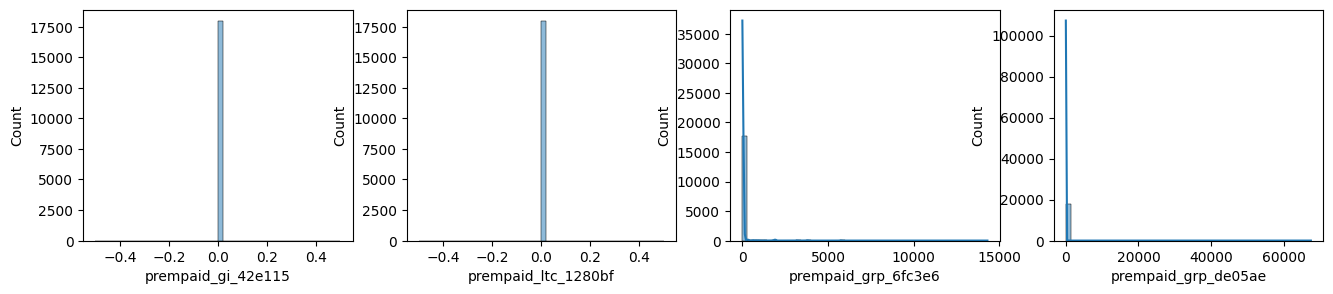

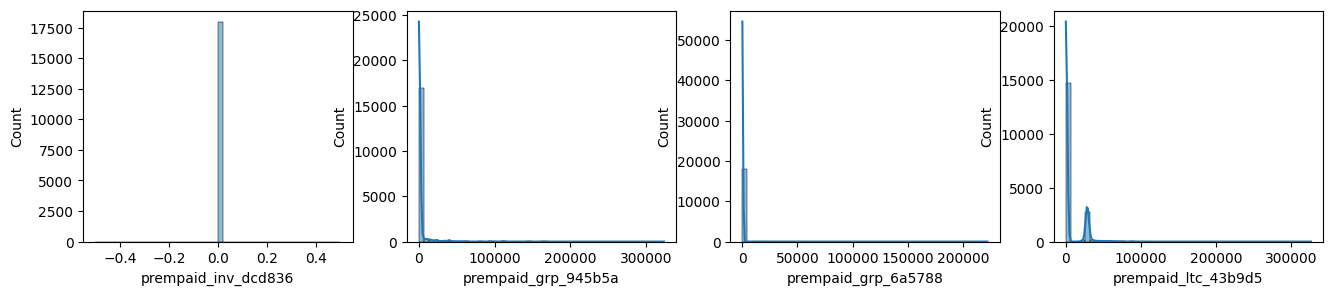

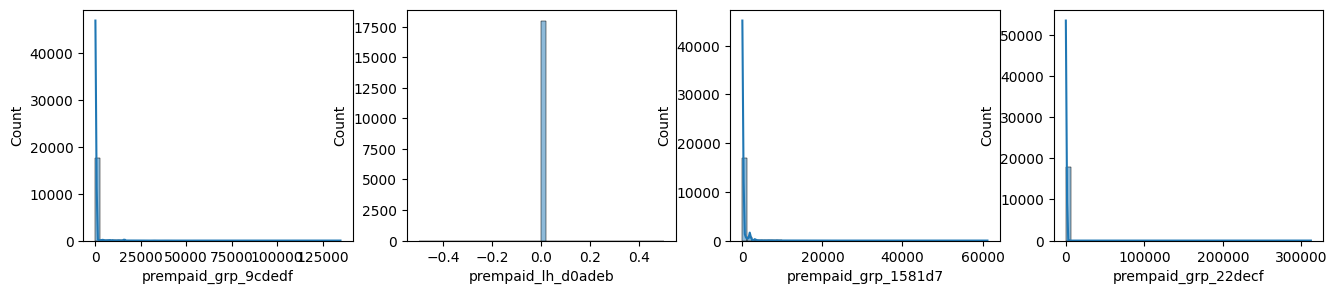

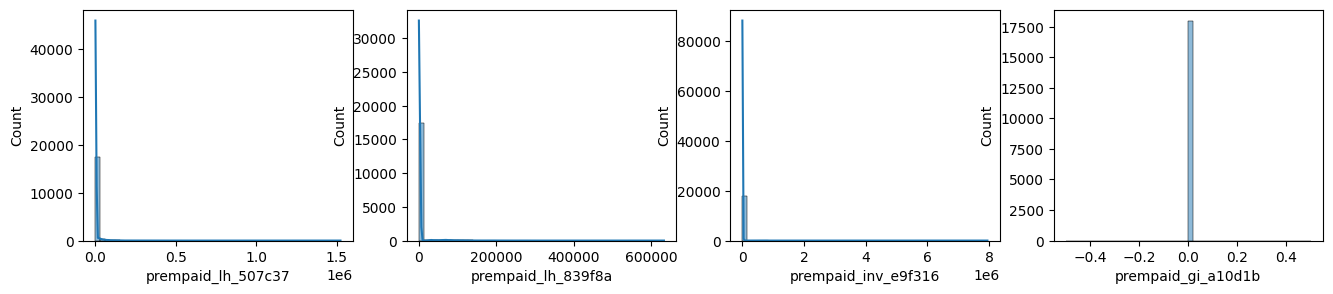

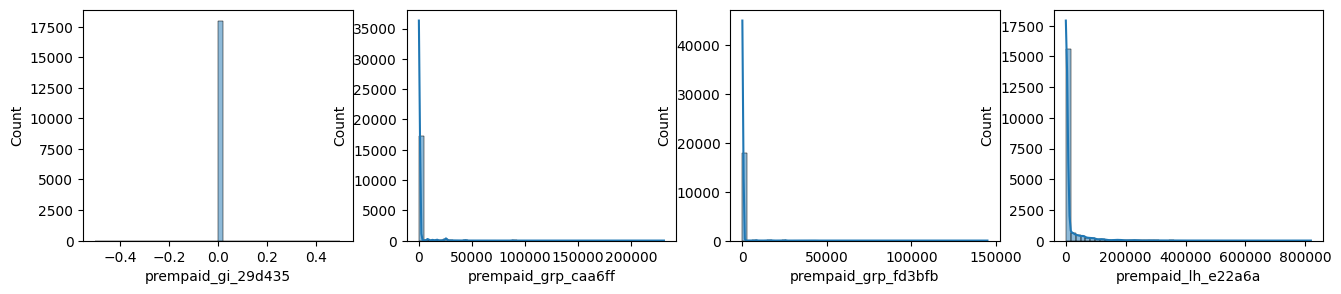

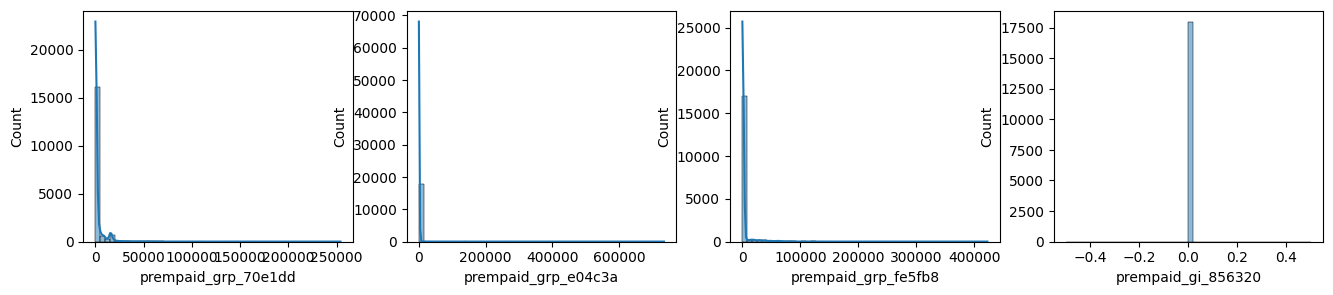

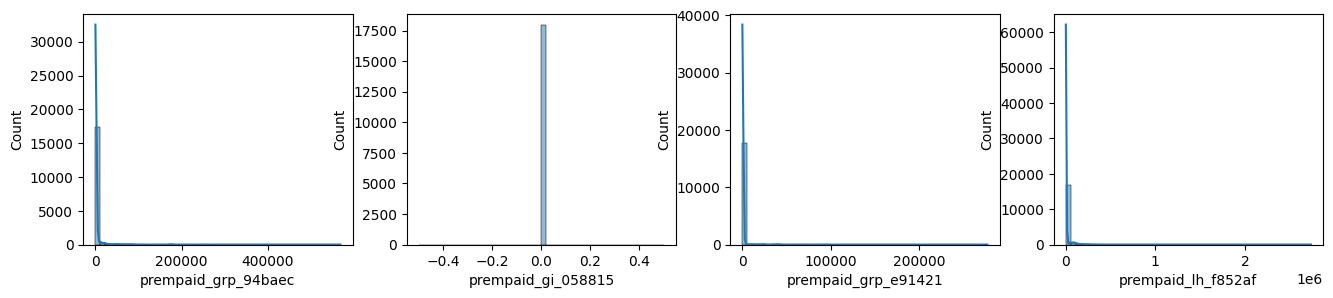

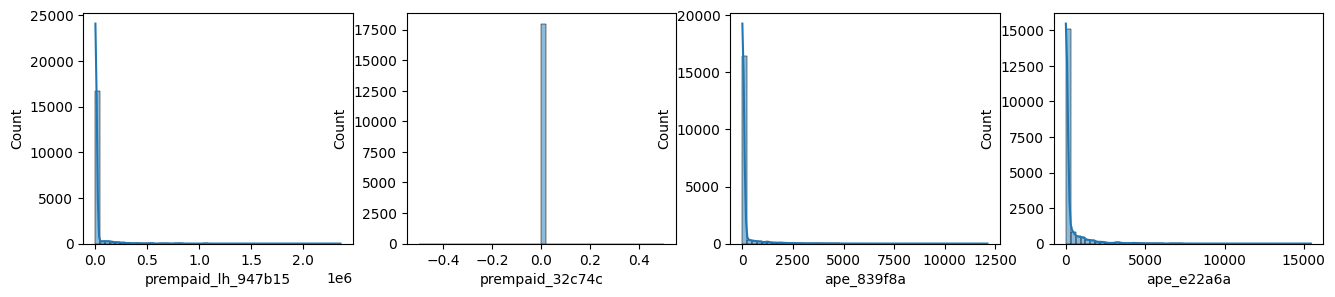

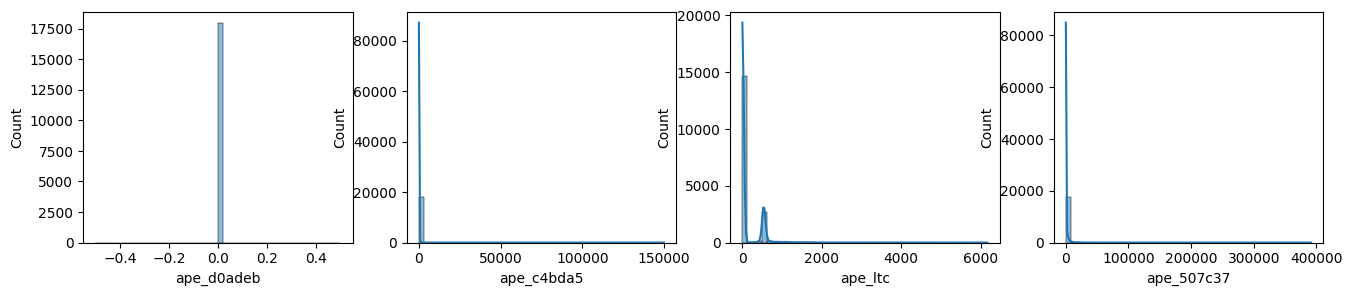

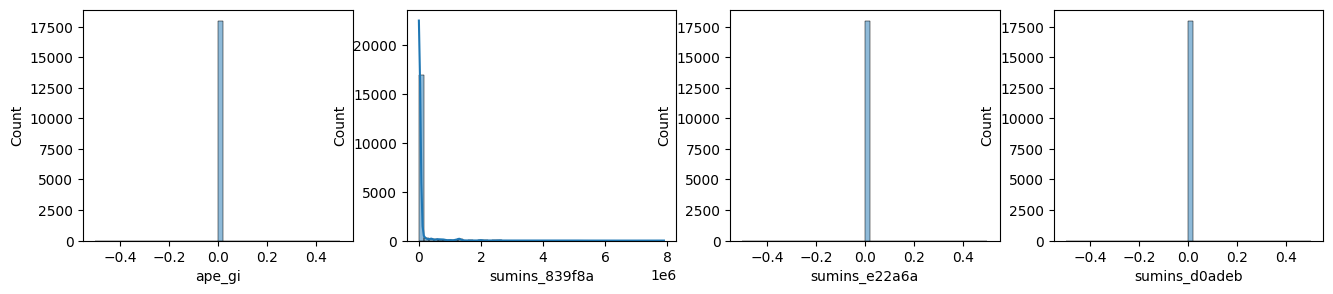

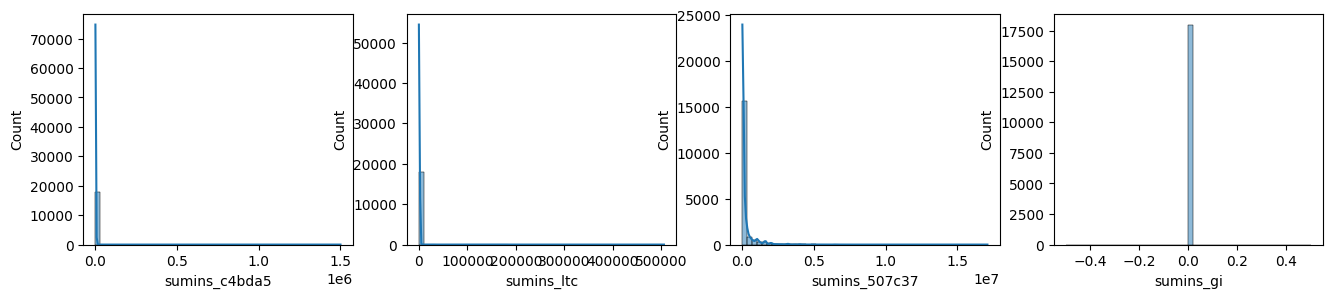

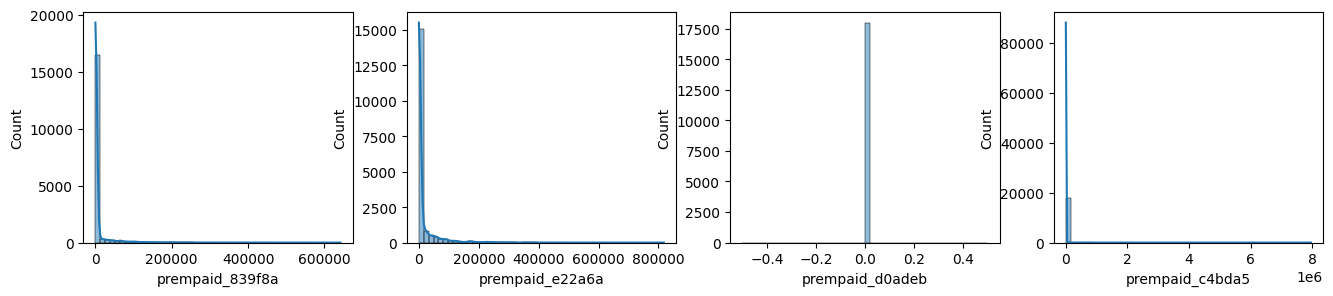

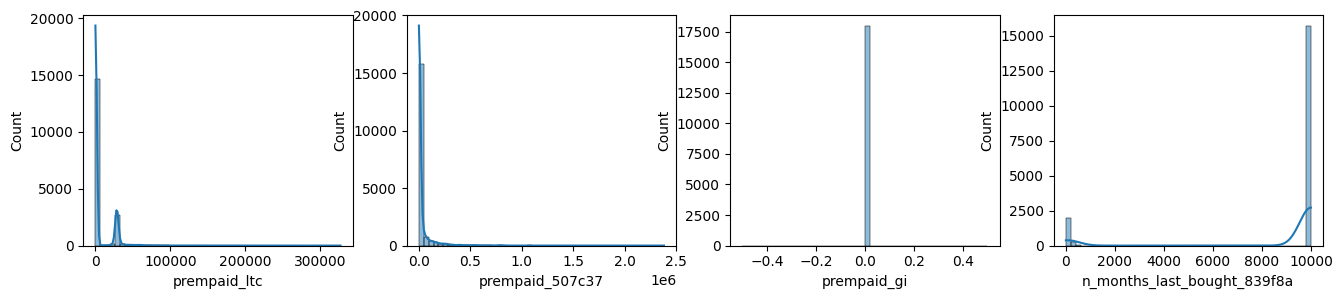

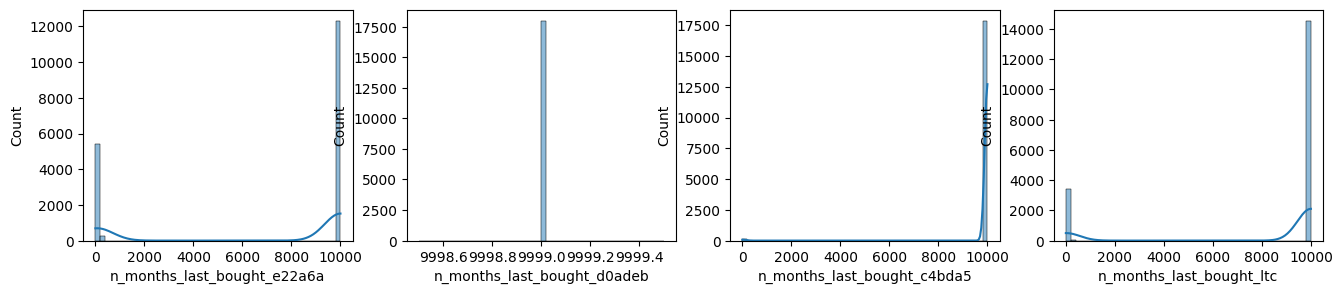

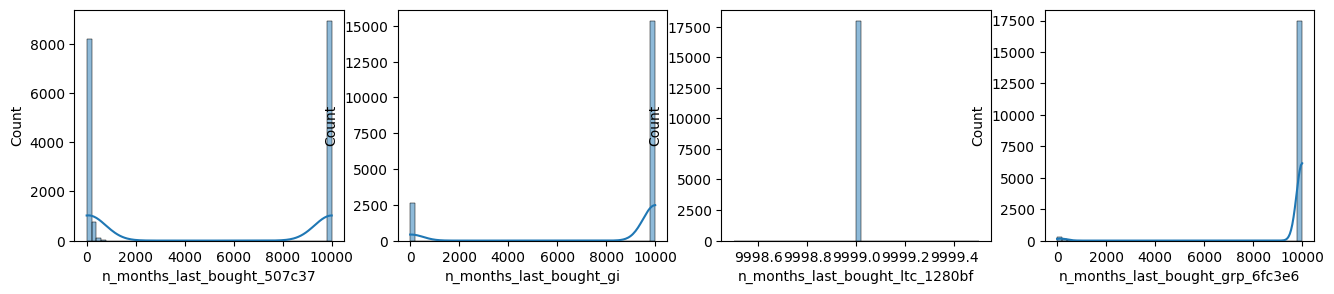

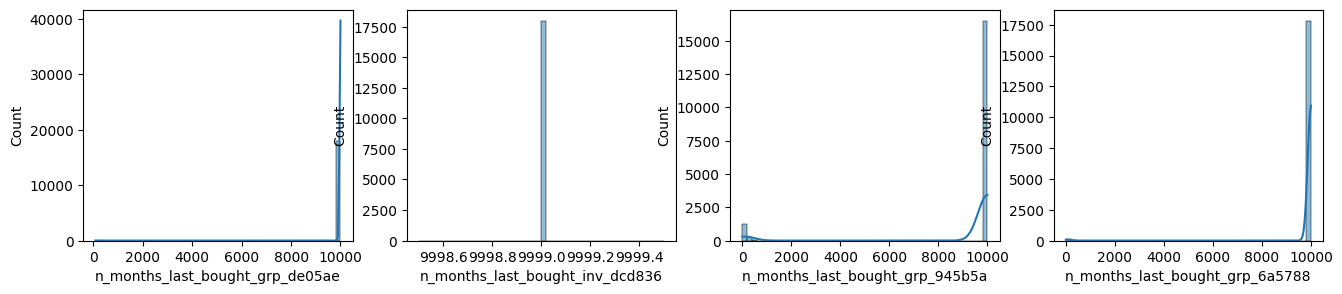

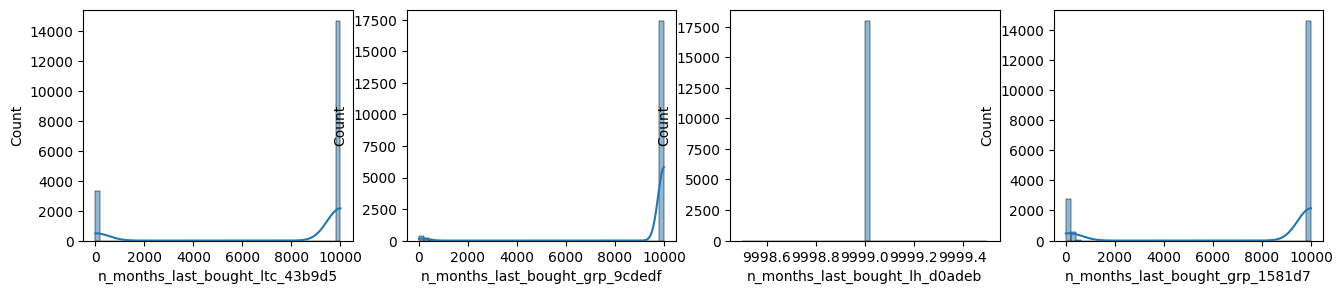

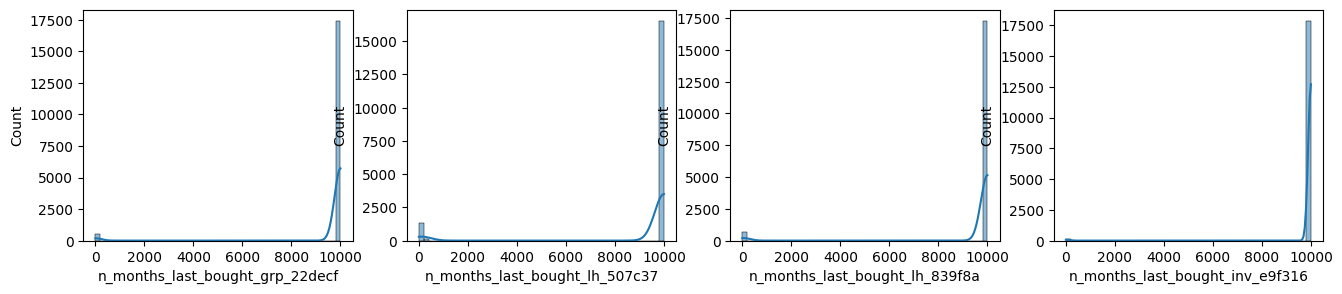

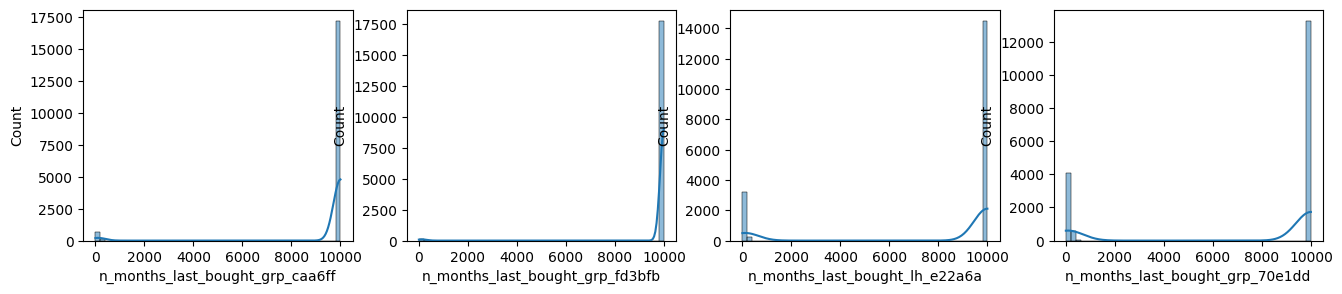

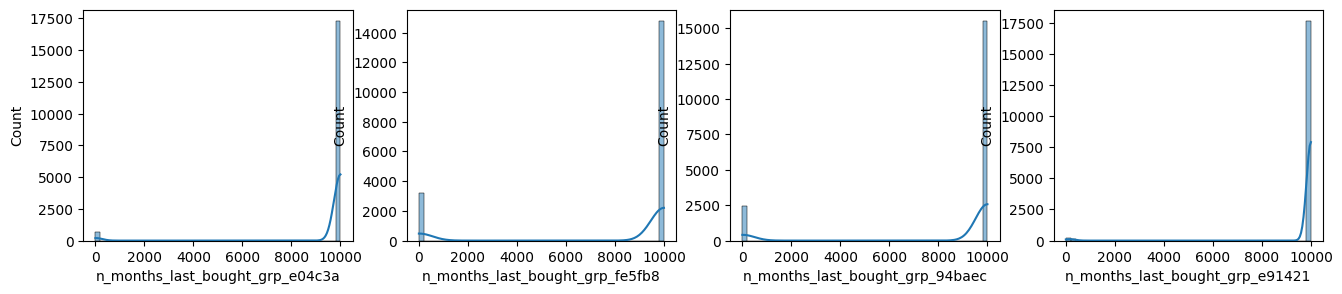

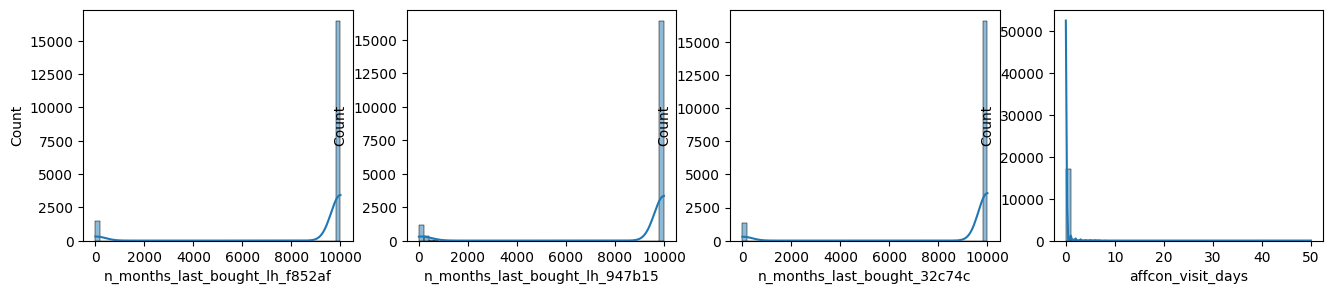

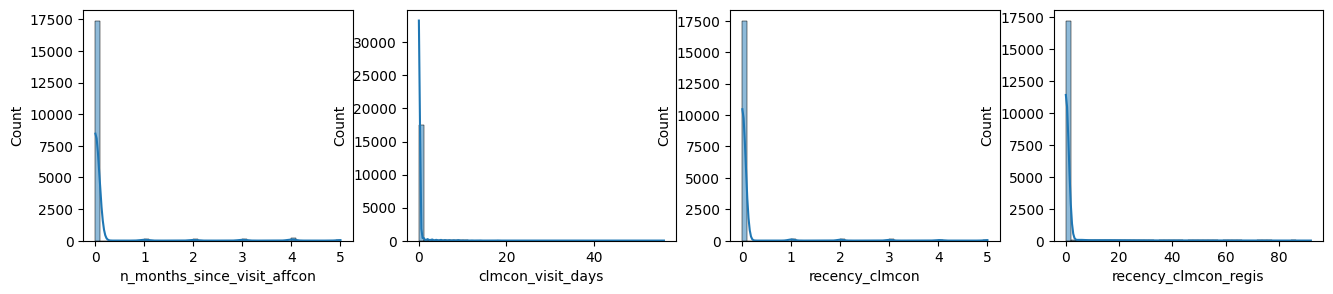

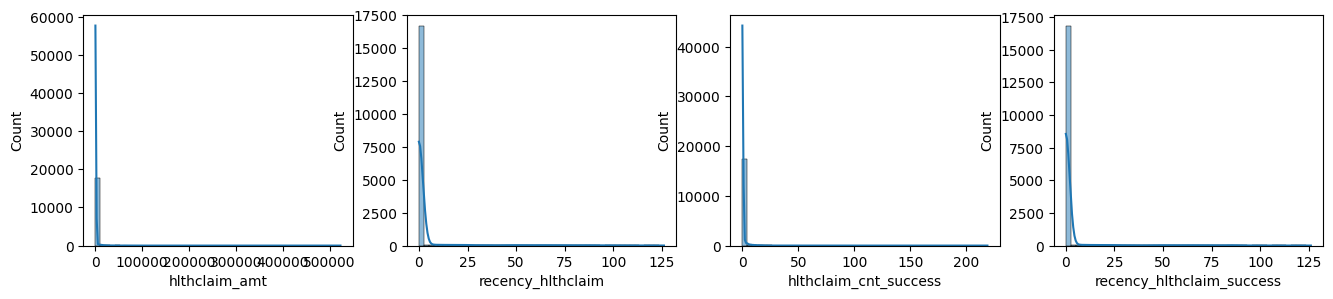

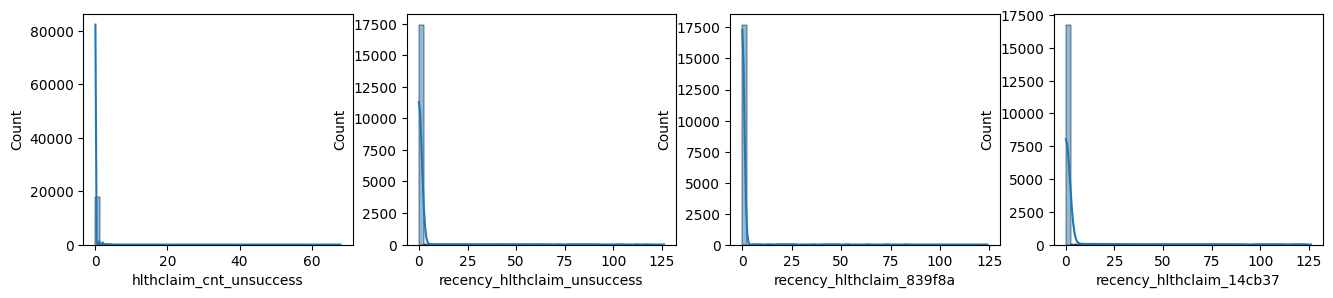

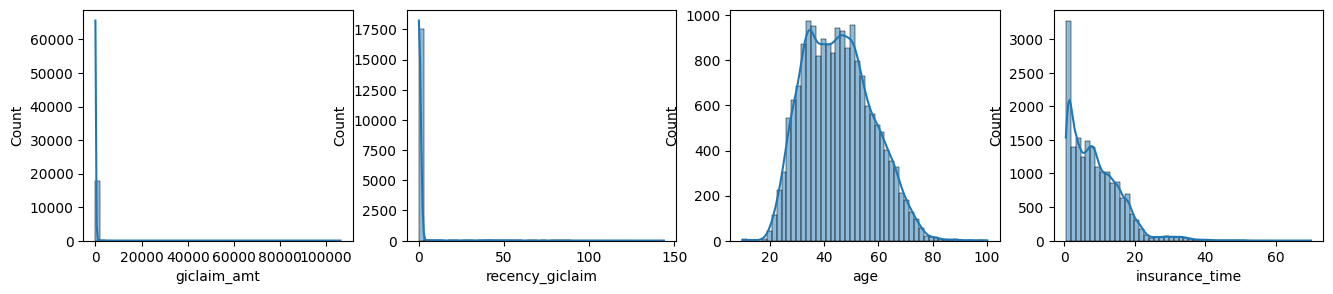

In [40]:
from sklearn.preprocessing import power_transform

ncols = 4
for i, f in enumerate(numercial_columns):
    if i % ncols == 0:
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Continuous features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data[f], kde=True, bins=50)
    plt.xlabel(f)
plt.show()

We can see that some columns have `variance == 0` and columns with `n_months_` include uninterpretable values e.g. 9999 months. We chose to drop them.

In [41]:
var_df = data[numercial_columns].var()
zero_var_columns = var_df[var_df == 0].index.values

In [42]:
todrop = []
numerical_features = []

for c in numercial_columns:
    if ("n_months_" not in c) and (c not in zero_var_columns):
        numerical_features.append(c)
    else:
        todrop.append(c)

data = data.drop(columns=todrop)

# ncols = 4
# for i, f in enumerate(numerical_features):
#     if i % ncols == 0:
#         if i > 0: plt.show()
#         plt.figure(figsize=(16, 3))
#         if i == 0: plt.suptitle('Continuous features', fontsize=20, y=1.02)
#     plt.subplot(1, ncols, i % ncols + 1)
#     sns.histplot(np.log(data[f] + 1e-6), kde=True, bins=50)
#     plt.xlabel(f)
# plt.show()

##### Analyze Binary Columns

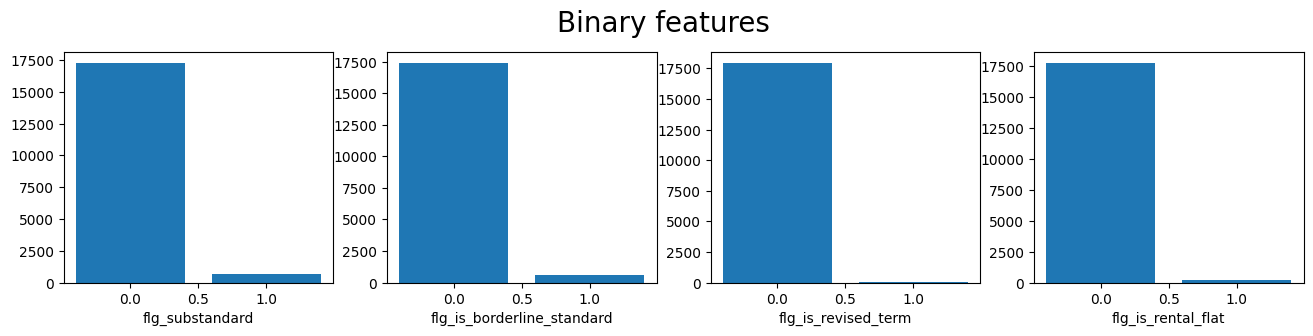

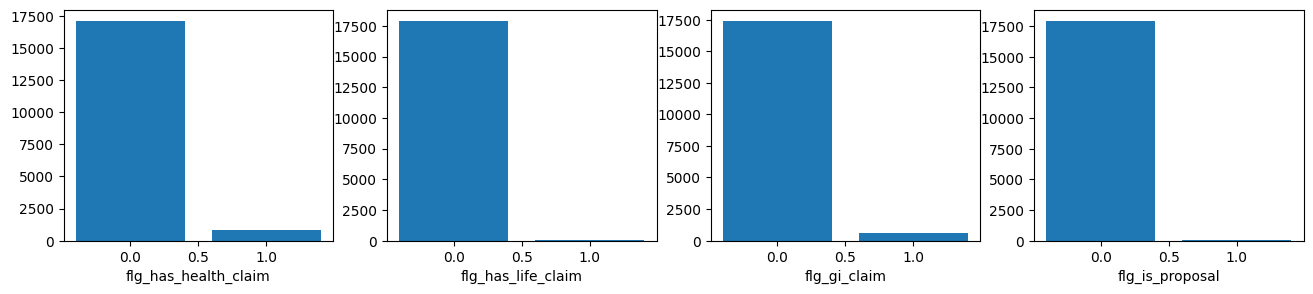

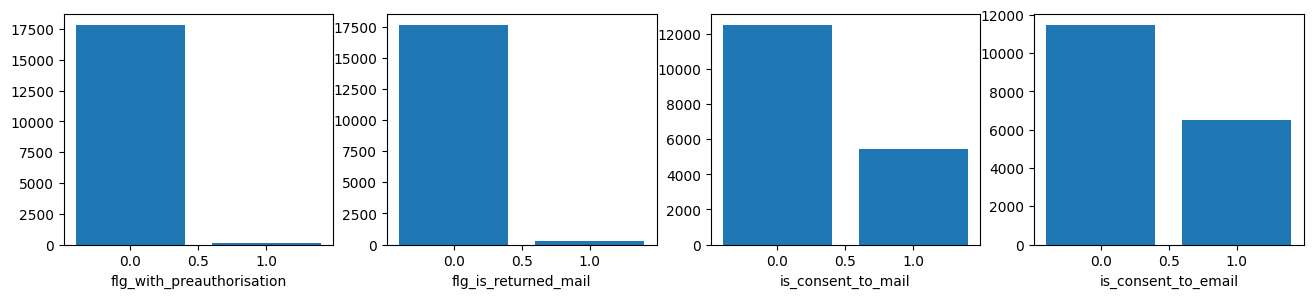

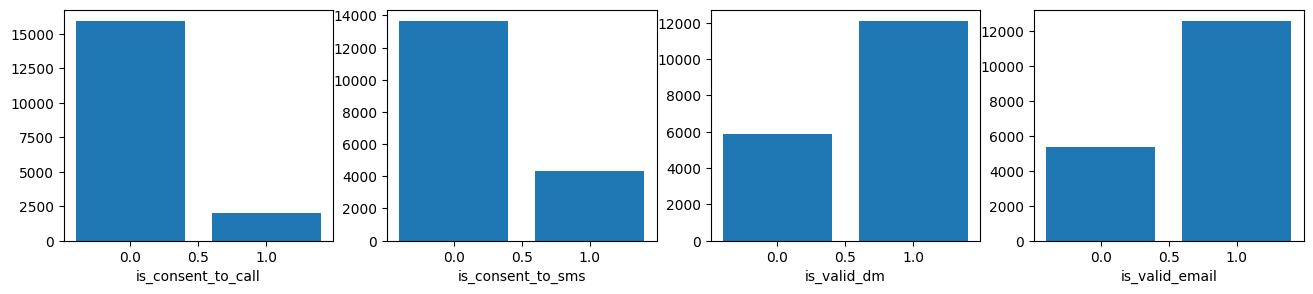

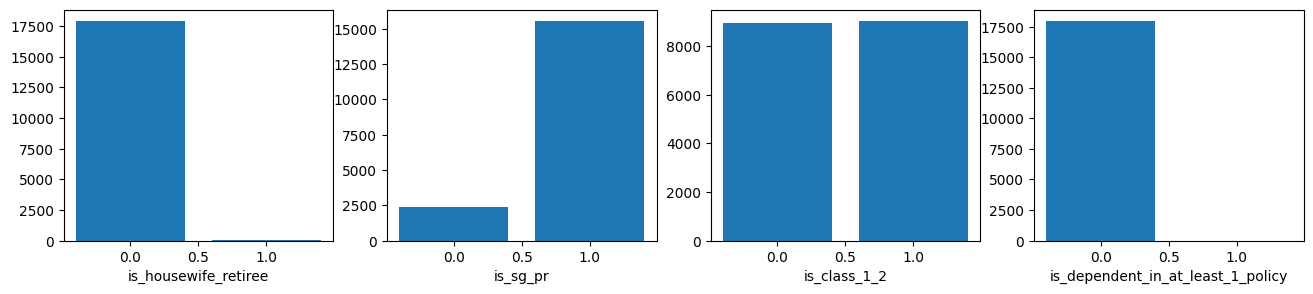

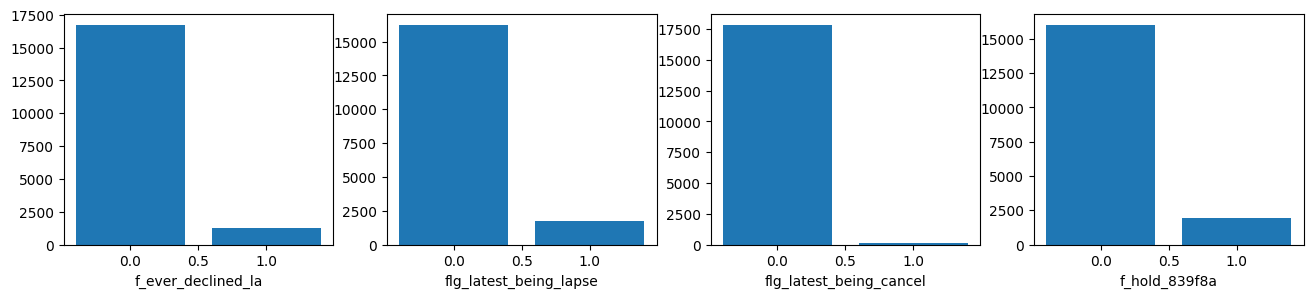

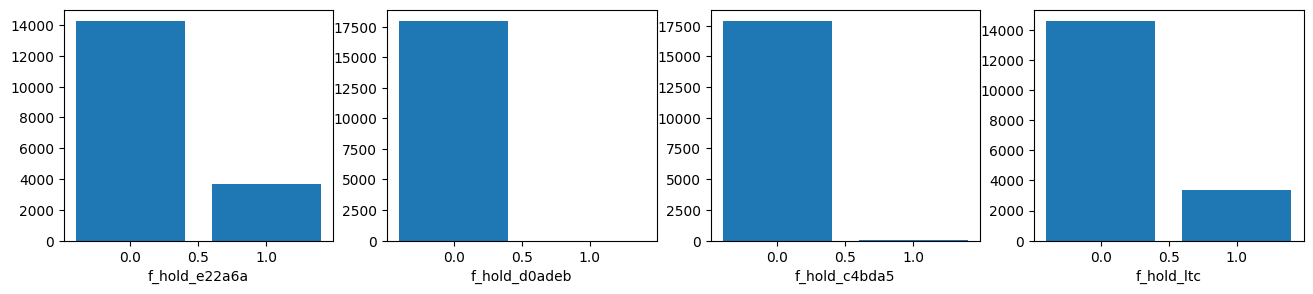

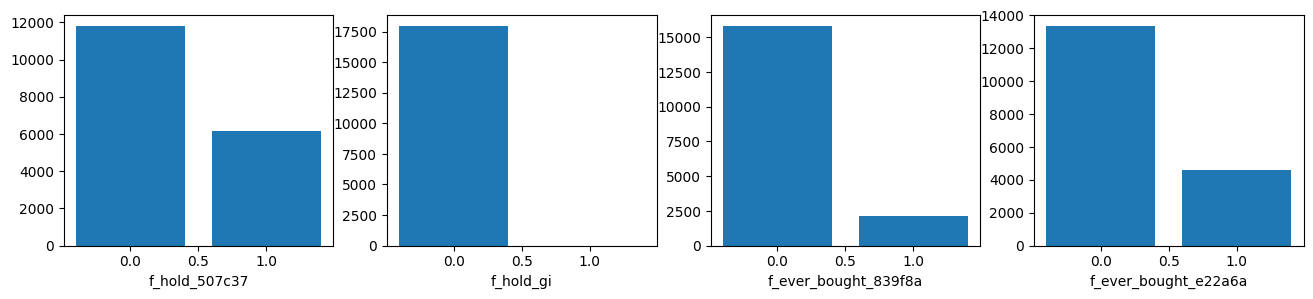

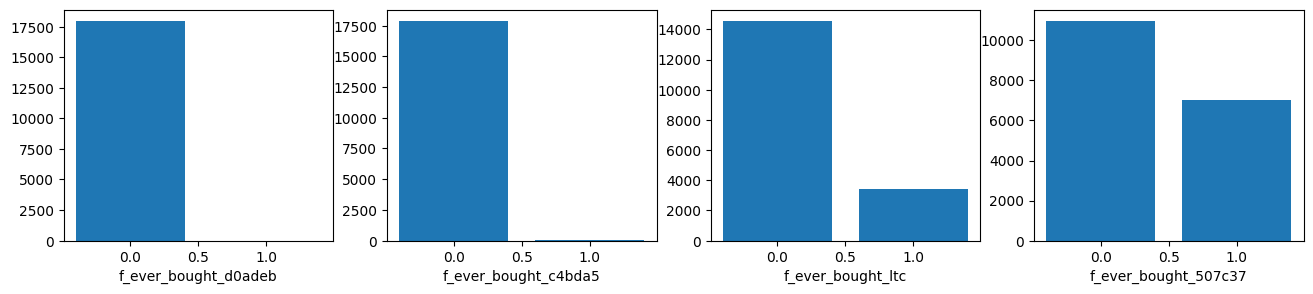

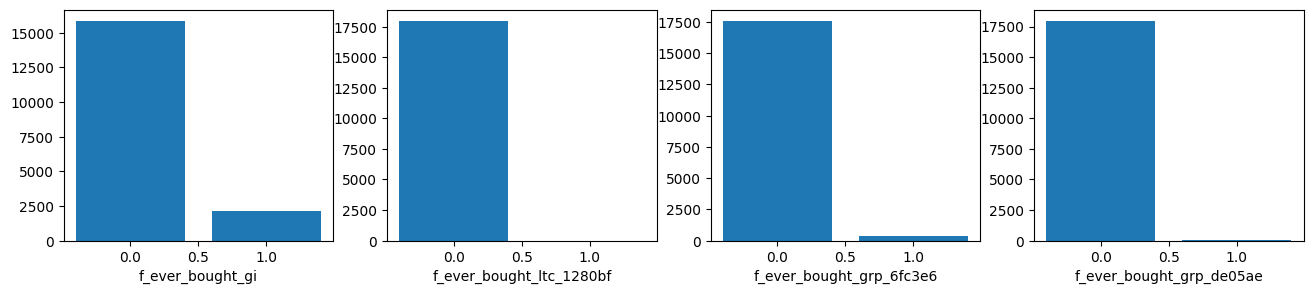

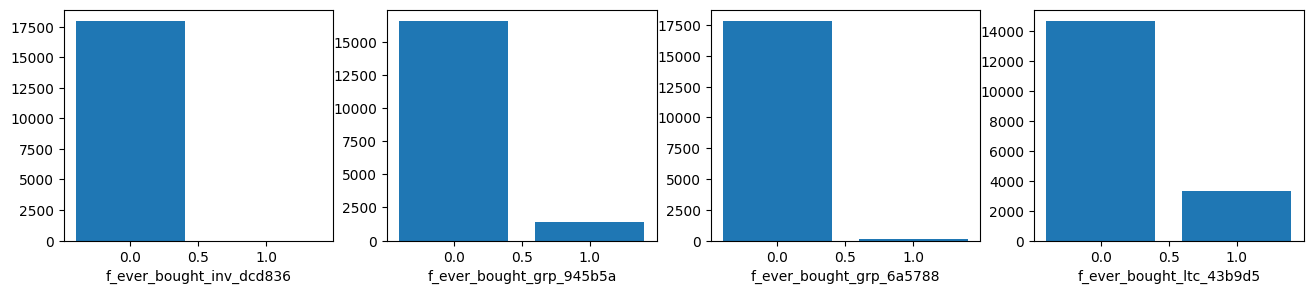

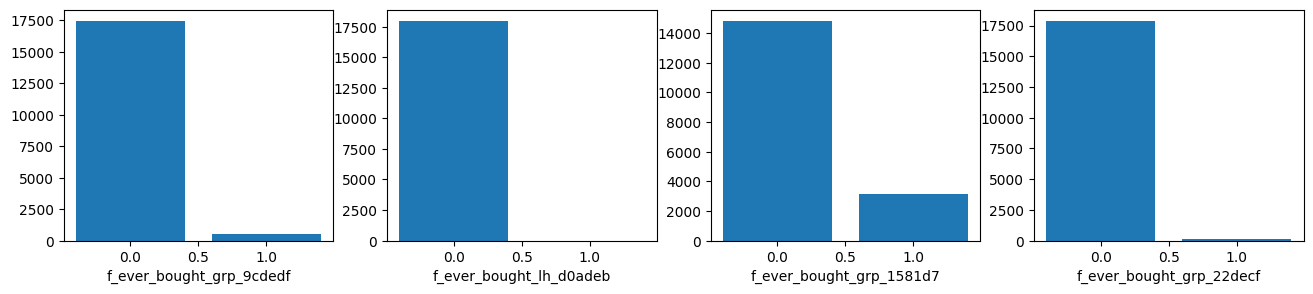

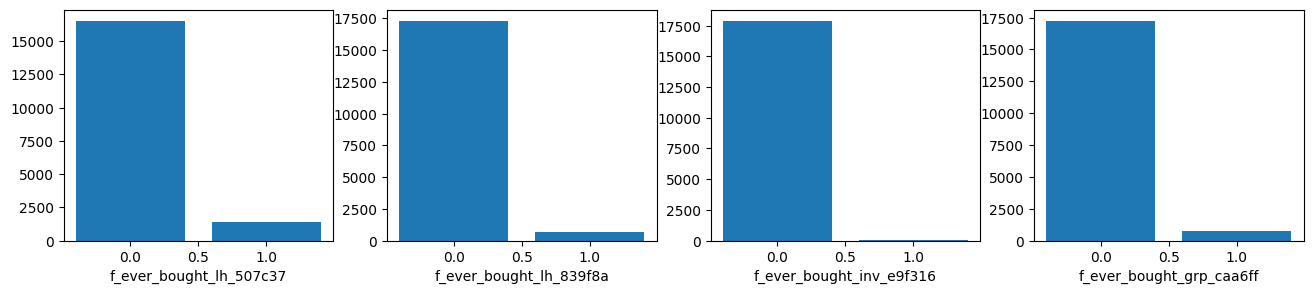

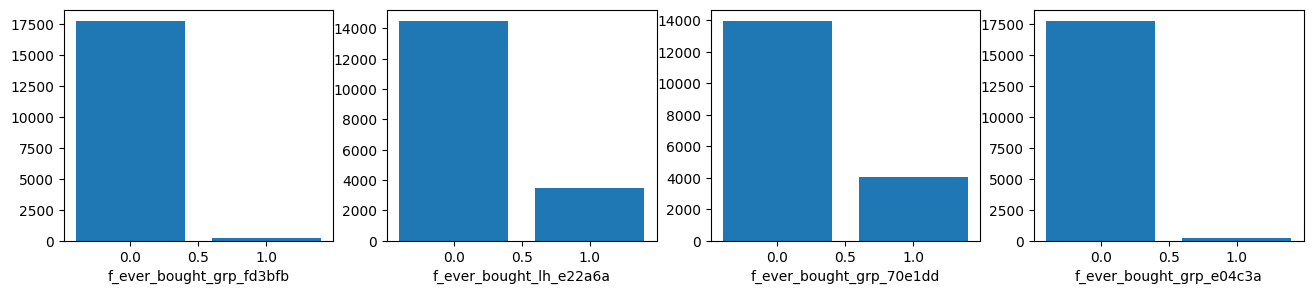

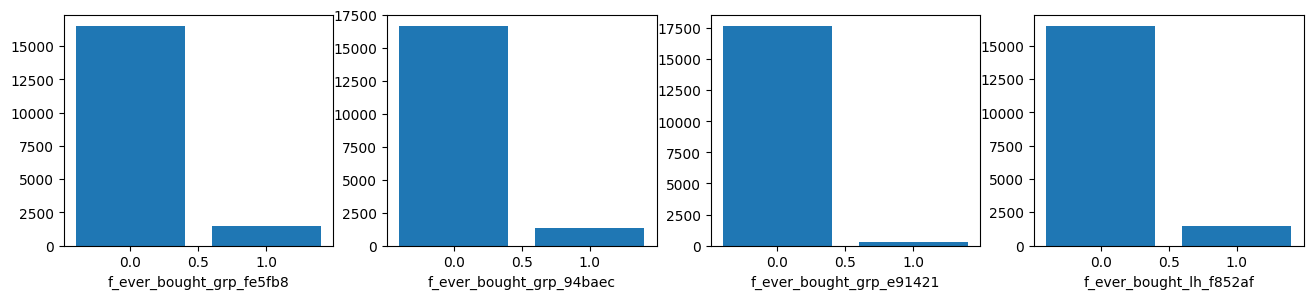

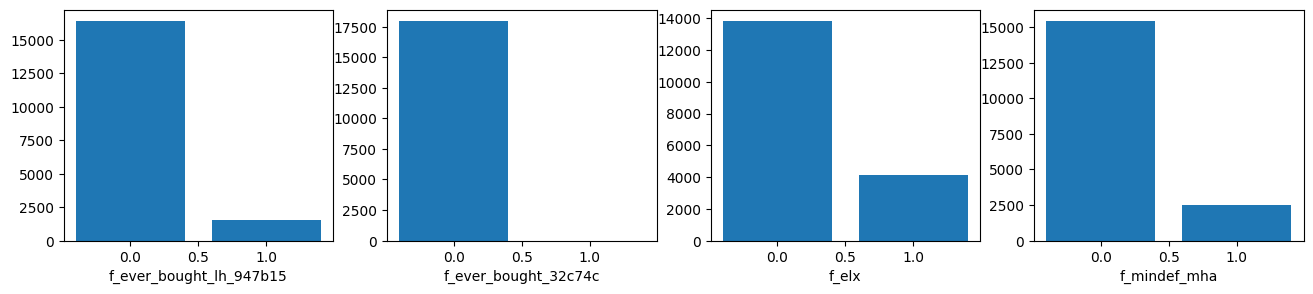

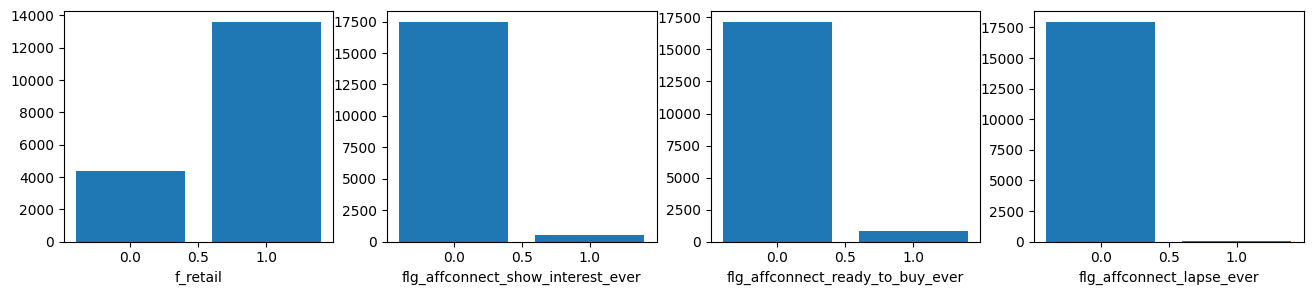

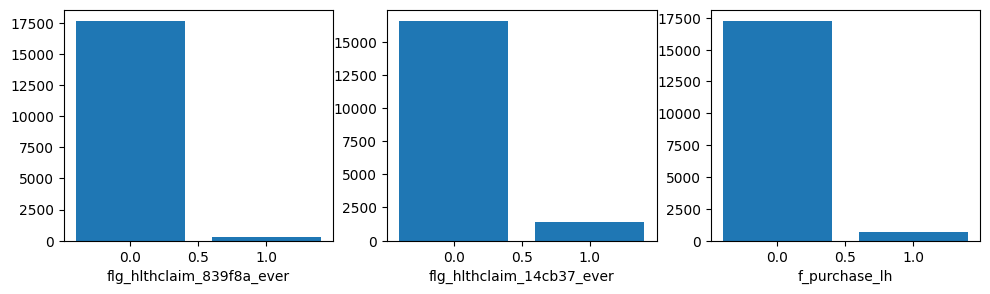

In [43]:
binary_features = []

for c in data.columns:
    if c not in categorical and data[c].values.dtype == np.int8:
        binary_features.append(c)

ncols = 4
for i, f in enumerate(binary_features):
    if i % ncols == 0:
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Binary features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.bar([0,1], [len(data[f])-data[f].values.sum(), data[f].values.sum()])
    plt.xlabel(f)
plt.show()

### Feature Engineering

##### Encode Categorical Columns

In [44]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
data = data.reset_index(drop=True)

categorical_features = []

for col in categorical:
    encoder = OneHotEncoder(sparse_output=False)
    oh = encoder.fit_transform(data[[col]])
    m = oh.shape[-1]
    labels = [f"{col}_{i}" for i in range(m)]
    categorical_features += labels
    data[labels] = oh.astype(np.int8)

data = data.drop(columns = categorical)

##### Calc stats of ape_lh, sumins_lh, prempaid_lh

In [45]:
data['ae_lh_sum'] = data.filter(regex='^ape_lh_.*').sum(axis=1)
data['smins_lh_sum'] = data.filter(regex='^sumins_lh_.*').sum(axis=1)
data['pempaid_lh_sum'] = data.filter(regex='^prempaid_lh_.*').sum(axis=1)
data['ae_lh_mean'] = data.filter(regex='^ape_lh_.*').mean(axis=1)
data['smins_lh_mean'] = data.filter(regex='^sumins_lh_.*').mean(axis=1)
data['pempaid_lh_mean'] = data.filter(regex='^prempaid_lh_.*').mean(axis=1)
data['ae_lh_std'] = data.filter(regex='^ape_lh_.*').std(axis=1)
data['smins_lh_std'] = data.filter(regex='^sumins_lh_.*').std(axis=1)
data['pempaid_lh_std'] = data.filter(regex='^prempaid_lh_.*').std(axis=1)
data['ae_lh_min'] = data.filter(regex='^ape_lh_.*').min(axis=1)
data['smins_lh_min'] = data.filter(regex='^sumins_lh_.*').min(axis=1)
data['pempaid_lh_min'] = data.filter(regex='^prempaid_lh_.*').min(axis=1)
data['ae_lh_max'] = data.filter(regex='^ape_lh_.*').max(axis=1)
data['smins_lh_max'] = data.filter(regex='^sumins_lh_.*').max(axis=1)
data['pempaid_lh_max'] = data.filter(regex='^prempaid_lh_.*').max(axis=1)

data = data.drop(columns=data.filter(regex='^prempaid_.*').columns.values)
data = data.drop(columns=data.filter(regex='^ape_.*').columns.values)
data = data.drop(columns=data.filter(regex='^sumins_.*').columns.values)

##### drop some binary columns

In [46]:
data = data.drop(columns=data.filter(regex='^f_ever_bought.*').columns.values)
data = data.drop(columns=data.filter(regex='^f_hold.*').columns.values)

##### Scale Numerical Features

In [47]:
numerical_features = []

for col in data.columns:
    if data[col].dtype == np.float64:
        numerical_features.append(col)

scaler = RobustScaler()
data_scaled = data.copy()

numerical_features = numerical_features
data_scaled[numerical_features] = scaler.fit_transform(data_scaled[numerical_features])
# to_drop = numerical_features[:-2]

# print(to_drop)
# data_scaled = data_scaled.drop(columns=to_drop)

### Modelling

In [48]:
target_column = "f_purchase_lh"

In [49]:
X, y = data_scaled.drop(columns=[target_column], inplace=False), data_scaled[target_column]

##### 5 fold Stratified k fold validation

In [59]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

indexs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    indexs.append((train_index, test_index))

val_score = 0

for i in range(len(indexs)):
    fold_index = indexs[i]

    X_train, X_val, y_train, y_val = X.iloc[fold_index[0]], X.iloc[fold_index[1]], y.iloc[fold_index[0]], y.iloc[fold_index[1]]

    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    # X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    # X_train, y_train = ADASYN(random_state=42).fit_resample(X_train, y_train)

    clf = XGBClassifier(max_depth=5, booster="dart", objective="binary:logistic", device="cuda")
    # clf = LGBMClassifier(objective="binary", max_depth=4, random_state=42)
    # clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = clf.predict(X_val)

    f1 = f1_score(y_val, y_val_pred)
    val_score += f1
    print(f"Fold {i+1}")
    print(f"F1: {f1}")
    print(classification_report(y_val, y_val_pred))

print(f"CV: {val_score/len(indexs)}")

Fold 1
F1: 0.20118343195266272
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3457
           1       0.63      0.12      0.20       142

    accuracy                           0.96      3599
   macro avg       0.80      0.56      0.59      3599
weighted avg       0.95      0.96      0.95      3599

Fold 2
F1: 0.2872340425531915
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3457
           1       0.59      0.19      0.29       142

    accuracy                           0.96      3599
   macro avg       0.78      0.59      0.63      3599
weighted avg       0.95      0.96      0.95      3599

Fold 3
F1: 0.2566844919786096
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3456
           1       0.53      0.17      0.26       142

    accuracy                           0.96      3598
   macro avg       0.75      0.58    

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

##### Cell to check testing_hidden_data function

In [51]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform.

All relevant code MUST be included in this function.'''
    result = []
    return result

In [52]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!